In [86]:
!wget "http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat"
!wget "http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat"
!wget "http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat"
     

URL transformed to HTTPS due to an HSTS policy
--2023-04-20 12:52:19--  https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M)
Saving to: ‘Indian_pines_corrected.mat.10’

Indian_pines_correc 100%[===================>]   5.68M  1.79MB/s    in 3.2s    

2023-04-20 12:52:23 (1.79 MB/s) - ‘Indian_pines_corrected.mat.10’ saved [5953527/5953527]

URL transformed to HTTPS due to an HSTS policy
--2023-04-20 12:52:24--  https://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1125 (1.1K)
Saving to: ‘Indian_pines_gt.mat.5’

Indian_pines_gt.mat 100%[===================>]   1

In [87]:
# Importing librar 
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from keras.models import Sequential, Model
from sklearn.svm import SVC    
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import (accuracy_score,confusion_matrix, classification_report)
from tensorflow.keras.models import load_model, Sequential
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tqdm import tqdm
from time import time
from keras.layers import Activation, Dense, Dropout
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, BatchNormalization, Input
from keras.utils import to_categorical
from numpy.random import seed
seed(11)

In [88]:
# Load hyperspectral data and ground_truth
data =loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
gt=loadmat('Indian_pines_gt.mat')['indian_pines_gt']
print(f'Data Shape: {data.shape[:-1]}\nNumber of Bands: {data.shape[-1]}')

Data Shape: (145, 145)
Number of Bands: 200


In [89]:
df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1))
df.columns = [f'band{i}' for i in range(1, df.shape[-1]+1)]
df['class'] = gt.ravel()

In [90]:
df.head()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band192,band193,band194,band195,band196,band197,band198,band199,band200,class
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,...,1094,1090,1112,1090,1062,1069,1057,1020,1020,3
1,2580,4266,4502,4426,4853,5249,5352,5353,5347,5065,...,1108,1104,1117,1091,1079,1085,1064,1029,1020,3
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,...,1111,1114,1114,1100,1065,1092,1061,1030,1016,3
3,2749,4258,4603,4493,4958,5234,5417,5355,5349,5096,...,1122,1108,1109,1109,1071,1088,1060,1030,1006,3
4,2746,4018,4675,4417,4886,5117,5215,5096,5098,4834,...,1110,1107,1112,1094,1072,1087,1052,1034,1019,3


In [131]:
X = df[df['class']!=0].iloc[:, :-1].values
y = tf.keras.utils.to_categorical(df[df['class']!=0].iloc[:, -1].values , 
                                  num_classes= np.unique(gt).shape[0], 
                                  dtype='float32') 

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.30)
print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}") 


X_train: (7174, 200)
y_train: (7174, 17)
X_test: (3075, 200)
y_test: (3075, 17)


In [133]:
# convolutional layers

model = Sequential(name='cnn')

model.add(Input(shape=(X_train.shape[1], 1), name='Input_Layer'))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', name='Conv_Layer1'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', name='Conv_Layer2'))
model.add(MaxPooling1D(pool_size=2, name='MaxPooling1'))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu', name='Conv_Layer3'))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', name='Conv_Layer4'))
model.add(MaxPooling1D(pool_size=2, name='MaxPooling2'))

model.add(Conv1D(filters=256, kernel_size=3, activation='relu', name='Conv_Layer5'))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', name='Conv_Layer6'))
model.add(MaxPooling1D(pool_size=2, name='MaxPooling3'))

model.add(Flatten(name='Flatten_Layer'))
model.add(Dense(units=512, activation='relu', name='Layer1'))
model.add(Dropout(rate=0.2, name='Dropout1'))
model.add(Dense(units=256, activation='relu', name='Layer2'))
model.add(Dropout(rate=0.2, name='Dropout2'))
model.add(Dense(units=128, activation='relu', name='Layer3'))
model.add(Dropout(rate=0.2, name='Dropout3'))

model.add(Dense(units=y_train.shape[1], activation='softmax', name='Output_Layer'))

In [134]:
model.summary()

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_Layer1 (Conv1D)        (None, 198, 64)           256       
                                                                 
 Conv_Layer2 (Conv1D)        (None, 196, 64)           12352     
                                                                 
 MaxPooling1 (MaxPooling1D)  (None, 98, 64)            0         
                                                                 
 Conv_Layer3 (Conv1D)        (None, 96, 128)           24704     
                                                                 
 Conv_Layer4 (Conv1D)        (None, 94, 128)           49280     
                                                                 
 MaxPooling2 (MaxPooling1D)  (None, 47, 128)           0         
                                                                 
 Conv_Layer5 (Conv1D)        (None, 45, 256)           98560   

In [135]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [136]:
early_stop = EarlyStopping(monitor = 'val_loss',
                            mode = 'min',
                            min_delta = 0,
                            patience = 10,
                            restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath = 'Salinas_Model.h5', 
                             monitor = 'val_loss', 
                             mode ='min', 
                             save_best_only = True)


tensorboard = TensorBoard(log_dir='SA_logs/{}'.format(time()))

In [137]:
# train the network
history =model.fit(X_train,y_train, epochs =30, batch_size = 32,validation_data = (X_test, y_test), callbacks=[early_stop,checkpoint,tensorboard])
loss, acc = model.evaluate(X_test, y_test, batch_size=32)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

Epoch 1/30
225/225 [==============================] - 24s 95ms/step - loss: 3.4665 - accuracy: 0.3394 - val_loss: 1.5130 - val_accuracy: 0.5112
Epoch 2/30
225/225 [==============================] - 21s 92ms/step - loss: 1.5443 - accuracy: 0.4580 - val_loss: 1.4478 - val_accuracy: 0.5320
Epoch 3/30
225/225 [==============================] - 21s 92ms/step - loss: 1.3969 - accuracy: 0.5125 - val_loss: 1.2739 - val_accuracy: 0.5424
Epoch 4/30
225/225 [==============================] - 21s 94ms/step - loss: 1.2987 - accuracy: 0.5213 - val_loss: 1.1489 - val_accuracy: 0.5672
Epoch 5/30
225/225 [==============================] - 21s 92ms/step - loss: 1.2401 - accuracy: 0.5375 - val_loss: 1.1154 - val_accuracy: 0.5620
Epoch 6/30
225/225 [==============================] - 21s 92ms/step - loss: 1.1756 - accuracy: 0.5559 - val_loss: 1.1010 - val_accuracy: 0.5837
Epoch 7/30
225/225 [==============================] - 21s 92ms/step - loss: 1.1567 - accuracy: 0.5608 - val_loss: 1.0664 - val_accuracy:

In [138]:
hist = pd.DataFrame(data= history.history)

fig = go.Figure()

fig.add_trace(go.Scatter(x = hist.index, y = hist.loss.values,
                    mode='lines+markers',
                    name='Train Loss'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.accuracy.values,
                    mode='lines+markers',
                    name='Train Accuracy'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.val_loss.values,
                    mode='lines+markers', name='Test loss'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.val_accuracy.values,
                    mode='lines+markers', name='Test Accuracy'))

fig.show()

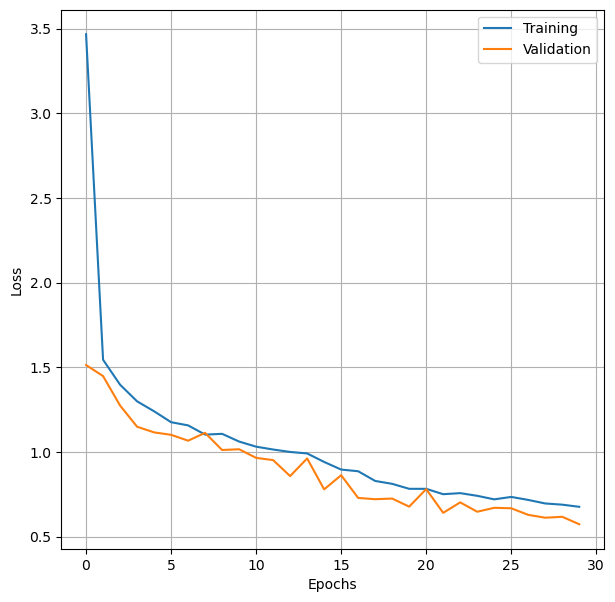

In [139]:
plt.figure(figsize=(7,7)) 
plt.grid() 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss') 
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right') 
plt.savefig("loss_curve.pdf") 
plt.show()

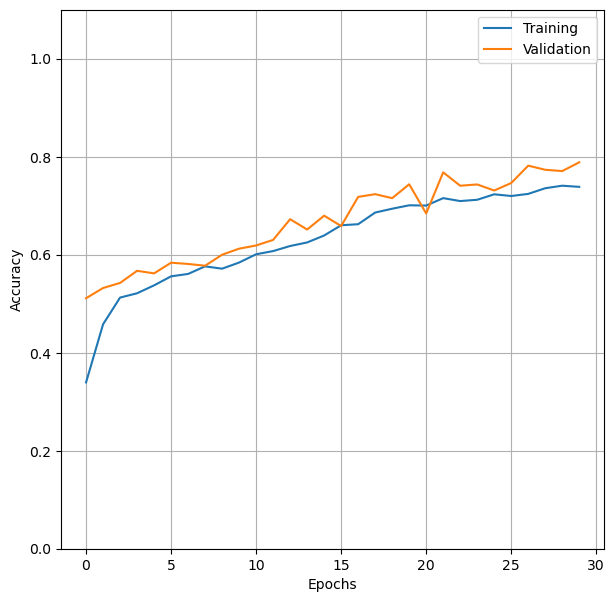

In [140]:
plt.figure(figsize=(7,7)) 
plt.ylim(0,1.1) 
plt.grid() 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy') 
plt.xlabel('Epochs') 
plt.legend(['Training','Validation']) 
plt.savefig("acc_curve.pdf") 
plt.show()

In [141]:
print(f"Accuracy: {acc*100}\nLoss: {loss}")

Accuracy: 78.86179089546204
Loss: 0.5731216073036194


# Support Vector Machine (SVM)

In [142]:
# Extract features using the trained CNN
feature_extractor = Model(inputs=model.inputs, outputs=model.layers[-4].output)
x_train_features = feature_extractor.predict(X_train)
x_test_features = feature_extractor.predict(X_test)
svm = SVC(kernel='linear')
svm.fit(x_train_features, np.argmax(y_train, axis=1))
svm_score = svm.score(x_test_features, np.argmax(y_test, axis=1))
print("SVM accuracy:", svm_score)

97/97 [==============================] - 2s 24ms/step
SVM accuracy: 0.8295934959349593


# Validation

In [143]:
# Predict labels for the test set
y_pred = svm.predict(x_test_features)
# Convert one-hot encoded labels to integers
y_test = np.argmax(y_test, axis=1)
# Compute classification report
print('Classification report:\n', classification_report(y_test, y_pred))

Classification report:
               precision    recall  f1-score   support

           1       0.56      0.64      0.60        14
           2       0.77      0.73      0.75       428
           3       0.78      0.75      0.76       249
           4       0.69      0.69      0.69        71
           5       0.94      0.90      0.92       145
           6       0.93      0.97      0.95       219
           7       0.71      0.62      0.67         8
           8       0.93      0.94      0.93       143
           9       0.75      0.50      0.60         6
          10       0.75      0.76      0.76       292
          11       0.79      0.82      0.81       737
          12       0.83      0.83      0.83       178
          13       1.00      0.98      0.99        61
          14       0.95      0.96      0.95       380
          15       0.79      0.70      0.74       116
          16       0.93      1.00      0.97        28

    accuracy                           0.83      3075
  

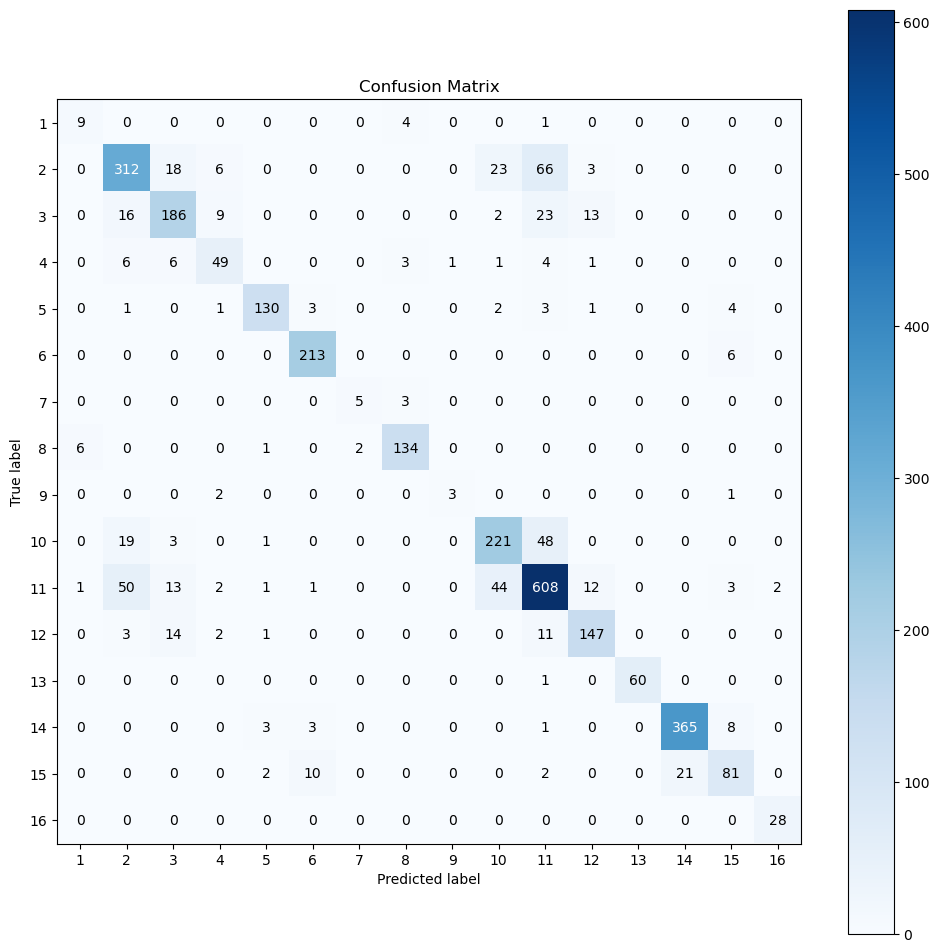

In [144]:
! pip install -q scikit-plot
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(
    y_test, 
    y_pred,
    figsize=(12,12));

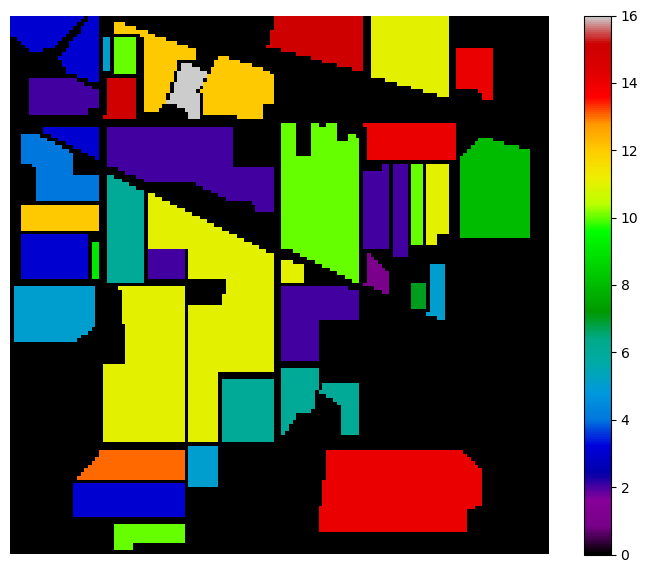

In [145]:
def plot_data(data):
  fig = plt.figure(figsize=(9, 7))
  plt.imshow(data, cmap='nipy_spectral')
  plt.colorbar()
  plt.axis('off')
  plt.show()
plot_data(gt)

  0%|          | 0/21025 [00:00<?, ?it/s]

1/1 [==============================] - 0s 219ms/step


  0%|          | 1/21025 [00:00<1:39:25,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 3/21025 [00:00<49:39,  7.05it/s]  

1/1 [==============================] - 0s 35ms/step


  0%|          | 5/21025 [00:00<41:22,  8.47it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 6/21025 [00:00<39:44,  8.81it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 7/21025 [00:00<39:01,  8.97it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 8/21025 [00:00<38:01,  9.21it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 10/21025 [00:01<33:46, 10.37it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 12/21025 [00:01<31:17, 11.19it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 14/21025 [00:01<29:22, 11.92it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 16/21025 [00:01<29:40, 11.80it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 18/21025 [00:01<28:32, 12.27it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 20/21025 [00:01<27:55, 12.54it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 23/21025 [00:02<24:41, 14.17it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 72/21025 [00:02<03:20, 104.64it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 83/21025 [00:04<16:28, 21.19it/s] 

1/1 [==============================] - 0s 36ms/step


  0%|          | 91/21025 [00:04<19:00, 18.36it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 97/21025 [00:05<19:24, 17.97it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 102/21025 [00:05<21:16, 16.40it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 106/21025 [00:06<23:03, 15.12it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 109/21025 [00:06<23:57, 14.55it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 112/21025 [00:06<25:26, 13.70it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 114/21025 [00:06<26:37, 13.09it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 116/21025 [00:06<27:11, 12.82it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 118/21025 [00:07<27:39, 12.60it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 147/21025 [00:07<07:09, 48.62it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 154/21025 [00:07<12:17, 28.32it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 159/21025 [00:08<15:39, 22.22it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 163/21025 [00:08<18:21, 18.93it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 167/21025 [00:08<17:44, 19.60it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 170/21025 [00:09<18:41, 18.59it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 218/21025 [00:09<04:48, 72.24it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 228/21025 [00:10<09:59, 34.69it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 235/21025 [00:10<13:28, 25.73it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 241/21025 [00:11<15:26, 22.44it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 246/21025 [00:11<17:06, 20.23it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 250/21025 [00:11<19:12, 18.02it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 253/21025 [00:12<20:44, 16.69it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 256/21025 [00:12<22:43, 15.24it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 258/21025 [00:12<23:25, 14.78it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 260/21025 [00:12<24:03, 14.38it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 262/21025 [00:13<24:50, 13.93it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 270/21025 [00:13<14:06, 24.53it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 292/21025 [00:13<06:19, 54.60it/s]

1/1 [==============================] - 0s 35ms/step


  1%|▏         | 299/21025 [00:13<11:23, 30.34it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 304/21025 [00:14<14:23, 24.00it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 308/21025 [00:14<16:38, 20.74it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 312/21025 [00:14<16:15, 21.24it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 315/21025 [00:14<16:33, 20.84it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 320/21025 [00:15<14:51, 23.21it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 362/21025 [00:15<04:13, 81.44it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 372/21025 [00:15<09:03, 37.98it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 380/21025 [00:16<12:40, 27.16it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 386/21025 [00:17<14:24, 23.86it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 391/21025 [00:17<15:22, 22.38it/s]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 395/21025 [00:17<17:41, 19.44it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 398/21025 [00:17<19:19, 17.79it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 401/21025 [00:18<20:28, 16.79it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 404/21025 [00:18<21:44, 15.81it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 406/21025 [00:18<22:59, 14.94it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 408/21025 [00:18<23:31, 14.61it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 437/21025 [00:18<06:20, 54.17it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 444/21025 [00:19<10:39, 32.20it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 449/21025 [00:19<13:25, 25.55it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 453/21025 [00:19<14:26, 23.75it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 457/21025 [00:20<15:24, 22.24it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 460/21025 [00:20<15:43, 21.80it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 465/21025 [00:20<14:37, 23.43it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 468/21025 [00:20<16:59, 20.16it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 507/21025 [00:20<04:38, 73.67it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 517/21025 [00:21<10:04, 33.94it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 524/21025 [00:22<13:24, 25.49it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 530/21025 [00:22<15:51, 21.55it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 534/21025 [00:22<15:30, 22.03it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 538/21025 [00:23<17:23, 19.63it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 541/21025 [00:23<18:58, 17.99it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 544/21025 [00:23<20:10, 16.92it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 547/21025 [00:23<21:30, 15.87it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 549/21025 [00:24<22:04, 15.46it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 551/21025 [00:24<22:58, 14.86it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 553/21025 [00:24<23:31, 14.50it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 582/21025 [00:24<05:44, 59.32it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 589/21025 [00:25<10:06, 33.68it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 595/21025 [00:25<13:28, 25.25it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 600/21025 [00:25<13:05, 26.00it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 604/21025 [00:26<15:25, 22.07it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 610/21025 [00:26<13:23, 25.42it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 614/21025 [00:26<16:17, 20.88it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 617/21025 [00:26<18:02, 18.85it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 652/21025 [00:26<05:30, 61.69it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 661/21025 [00:27<10:01, 33.83it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 668/21025 [00:28<13:10, 25.74it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 673/21025 [00:28<15:20, 22.12it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 677/21025 [00:28<15:25, 21.99it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 681/21025 [00:28<17:18, 19.60it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 684/21025 [00:29<18:43, 18.10it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 687/21025 [00:29<20:20, 16.67it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 689/21025 [00:29<21:03, 16.10it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 691/21025 [00:29<22:44, 14.91it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 693/21025 [00:29<24:10, 14.02it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 695/21025 [00:30<26:46, 12.66it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 697/21025 [00:30<27:57, 12.12it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 699/21025 [00:30<25:25, 13.33it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 727/21025 [00:30<06:01, 56.19it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 733/21025 [00:31<10:20, 32.68it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 738/21025 [00:31<13:12, 25.59it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 742/21025 [00:31<13:23, 25.24it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 746/21025 [00:31<14:39, 23.06it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 749/21025 [00:32<16:54, 19.99it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 762/21025 [00:32<10:09, 33.25it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▎         | 766/21025 [00:32<11:08, 30.30it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 797/21025 [00:32<04:44, 71.08it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 806/21025 [00:33<09:22, 35.94it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 813/21025 [00:33<12:55, 26.06it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 818/21025 [00:34<15:32, 21.67it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 822/21025 [00:34<15:17, 22.02it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 826/21025 [00:34<17:29, 19.25it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 829/21025 [00:35<18:41, 18.01it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 832/21025 [00:35<20:00, 16.82it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 834/21025 [00:35<21:15, 15.83it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 836/21025 [00:35<22:26, 15.00it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 838/21025 [00:35<23:06, 14.56it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 840/21025 [00:35<23:29, 14.32it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 842/21025 [00:36<24:39, 13.64it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 873/21025 [00:36<05:14, 64.03it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 881/21025 [00:36<09:54, 33.90it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 887/21025 [00:37<10:23, 32.28it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 892/21025 [00:37<13:05, 25.62it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 896/21025 [00:37<14:21, 23.37it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 900/21025 [00:37<15:11, 22.08it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 903/21025 [00:38<16:45, 20.02it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 907/21025 [00:38<15:55, 21.04it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 910/21025 [00:38<17:55, 18.70it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 913/21025 [00:38<17:32, 19.11it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 942/21025 [00:38<05:25, 61.73it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 950/21025 [00:39<10:01, 33.39it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 956/21025 [00:39<13:18, 25.15it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 961/21025 [00:40<15:25, 21.67it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 965/21025 [00:40<17:20, 19.27it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 969/21025 [00:40<16:21, 20.43it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 972/21025 [00:40<17:42, 18.88it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 975/21025 [00:41<19:24, 17.22it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 978/21025 [00:41<20:37, 16.21it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 980/21025 [00:41<21:42, 15.38it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 982/21025 [00:41<22:21, 14.94it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 984/21025 [00:41<23:32, 14.19it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 986/21025 [00:41<24:51, 13.43it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 988/21025 [00:42<25:57, 12.87it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 1020/21025 [00:42<05:25, 61.51it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 1027/21025 [00:42<10:42, 31.11it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 1032/21025 [00:43<10:32, 31.61it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 1037/21025 [00:43<13:39, 24.40it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 1041/21025 [00:43<14:28, 23.02it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 1044/21025 [00:43<14:47, 22.51it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 1047/21025 [00:44<16:47, 19.84it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 1050/21025 [00:44<16:41, 19.94it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 1053/21025 [00:44<17:04, 19.50it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 1056/21025 [00:44<18:53, 17.62it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 1058/21025 [00:44<20:20, 16.36it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 1060/21025 [00:44<21:18, 15.62it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 1087/21025 [00:45<05:50, 56.84it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 1093/21025 [00:45<10:55, 30.39it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 1098/21025 [00:46<14:15, 23.28it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 1102/21025 [00:46<16:18, 20.36it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 1105/21025 [00:46<17:38, 18.83it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 1108/21025 [00:46<18:47, 17.67it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 1111/21025 [00:47<18:25, 18.01it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 1114/21025 [00:47<17:54, 18.53it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 1117/21025 [00:47<19:28, 17.03it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 1119/21025 [00:47<20:29, 16.19it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 1121/21025 [00:47<21:03, 15.76it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 1123/21025 [00:47<22:28, 14.76it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 1125/21025 [00:47<22:56, 14.45it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 1127/21025 [00:48<23:20, 14.21it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 1129/21025 [00:48<23:28, 14.12it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 1131/21025 [00:48<23:57, 13.84it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 1133/21025 [00:48<24:06, 13.75it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 1166/21025 [00:48<04:19, 76.45it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 1175/21025 [00:49<07:11, 46.04it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 1182/21025 [00:49<10:02, 32.95it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 1187/21025 [00:49<11:57, 27.67it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 1191/21025 [00:50<12:57, 25.51it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 1195/21025 [00:50<14:34, 22.68it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 1198/21025 [00:50<15:54, 20.78it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 1201/21025 [00:50<19:34, 16.87it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 1203/21025 [00:51<20:57, 15.76it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 1205/21025 [00:51<22:02, 14.98it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 1207/21025 [00:51<22:56, 14.40it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 1230/21025 [00:51<06:46, 48.69it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 1236/21025 [00:51<10:28, 31.47it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 1241/21025 [00:52<13:26, 24.54it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 1245/21025 [00:52<15:30, 21.27it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 1248/21025 [00:52<17:12, 19.16it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 1251/21025 [00:53<18:21, 17.96it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 1254/21025 [00:53<19:23, 16.99it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 1258/21025 [00:53<17:46, 18.53it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 1261/21025 [00:53<19:28, 16.91it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 1263/21025 [00:53<20:17, 16.23it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 1265/21025 [00:53<21:23, 15.40it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 1267/21025 [00:54<21:57, 14.99it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 1269/21025 [00:54<22:57, 14.35it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 1271/21025 [00:54<23:17, 14.14it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 1273/21025 [00:54<23:41, 13.89it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 1275/21025 [00:54<23:50, 13.81it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 1277/21025 [00:54<24:49, 13.26it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 1311/21025 [00:54<04:29, 73.15it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 1319/21025 [00:55<05:29, 59.72it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 1326/21025 [00:55<08:57, 36.63it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 1331/21025 [00:55<10:43, 30.60it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 1335/21025 [00:56<11:56, 27.47it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 1339/21025 [00:56<14:31, 22.59it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 1343/21025 [00:56<13:56, 23.53it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 1346/21025 [00:56<16:04, 20.41it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 1349/21025 [00:57<18:07, 18.09it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 1351/21025 [00:57<19:03, 17.21it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 1353/21025 [00:57<19:52, 16.49it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 1355/21025 [00:57<20:36, 15.91it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1380/21025 [00:57<05:49, 56.16it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1386/21025 [00:58<09:40, 33.82it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 1391/21025 [00:58<12:46, 25.60it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1395/21025 [00:58<14:49, 22.07it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 1398/21025 [00:58<16:33, 19.76it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 1401/21025 [00:59<16:36, 19.69it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1404/21025 [00:59<16:29, 19.83it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1407/21025 [00:59<19:17, 16.94it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 1409/21025 [00:59<21:34, 15.15it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 1411/21025 [00:59<23:23, 13.97it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1413/21025 [01:00<24:33, 13.31it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1415/21025 [01:00<25:29, 12.82it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1417/21025 [01:00<25:31, 12.80it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 1419/21025 [01:00<25:56, 12.60it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1421/21025 [01:00<26:12, 12.46it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 1423/21025 [01:00<26:24, 12.37it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1427/21025 [01:01<19:56, 16.37it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 1429/21025 [01:01<20:42, 15.77it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1431/21025 [01:01<21:52, 14.93it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1433/21025 [01:01<22:32, 14.49it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1435/21025 [01:01<25:08, 12.98it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 1466/21025 [01:01<04:49, 67.56it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1474/21025 [01:02<09:32, 34.13it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 1480/21025 [01:02<10:55, 29.81it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 1485/21025 [01:03<12:26, 26.17it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1489/21025 [01:03<13:23, 24.30it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 1493/21025 [01:03<15:45, 20.65it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1496/21025 [01:03<17:05, 19.03it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1499/21025 [01:04<18:27, 17.62it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1528/21025 [01:04<06:08, 52.97it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1535/21025 [01:04<09:45, 33.27it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 1541/21025 [01:05<12:58, 25.02it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 1545/21025 [01:05<14:59, 21.66it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1549/21025 [01:05<14:49, 21.90it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 1552/21025 [01:05<16:38, 19.49it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1555/21025 [01:06<18:07, 17.90it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1558/21025 [01:06<19:30, 16.64it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1560/21025 [01:06<20:11, 16.07it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1562/21025 [01:06<20:46, 15.62it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1564/21025 [01:06<21:19, 15.21it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1566/21025 [01:06<22:17, 14.55it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1568/21025 [01:07<23:19, 13.90it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 1572/21025 [01:07<18:40, 17.36it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1574/21025 [01:07<19:46, 16.39it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1576/21025 [01:07<20:35, 15.74it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 1578/21025 [01:07<21:44, 14.91it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 1580/21025 [01:07<22:10, 14.62it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 1610/21025 [01:07<04:36, 70.24it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1618/21025 [01:08<09:14, 34.99it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 1624/21025 [01:08<10:33, 30.63it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1629/21025 [01:09<13:18, 24.30it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 1633/21025 [01:09<13:02, 24.80it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 1637/21025 [01:09<15:00, 21.52it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1640/21025 [01:09<16:49, 19.21it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 1643/21025 [01:10<18:07, 17.82it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 1646/21025 [01:10<17:32, 18.41it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1653/21025 [01:10<13:02, 24.76it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1677/21025 [01:10<05:31, 58.30it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 1684/21025 [01:11<09:29, 33.95it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 1690/21025 [01:11<12:25, 25.94it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1695/21025 [01:11<13:09, 24.48it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 1699/21025 [01:12<16:19, 19.73it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 1702/21025 [01:12<18:15, 17.64it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 1705/21025 [01:12<21:01, 15.31it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 1707/21025 [01:12<21:17, 15.12it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 1709/21025 [01:12<21:42, 14.83it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1711/21025 [01:13<22:08, 14.54it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 1713/21025 [01:13<22:18, 14.42it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1717/21025 [01:13<18:35, 17.30it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 1719/21025 [01:13<20:01, 16.06it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1721/21025 [01:13<20:57, 15.35it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1723/21025 [01:13<21:22, 15.05it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1725/21025 [01:14<22:00, 14.62it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 1756/21025 [01:14<04:38, 69.28it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 1763/21025 [01:14<08:35, 37.33it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 1769/21025 [01:14<10:12, 31.45it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 1774/21025 [01:15<12:53, 24.88it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 1778/21025 [01:15<13:00, 24.65it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 1782/21025 [01:15<16:12, 19.79it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 1785/21025 [01:16<18:17, 17.52it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▊         | 1797/21025 [01:16<11:36, 27.60it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▊         | 1801/21025 [01:16<15:03, 21.27it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 1825/21025 [01:16<06:52, 46.54it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 1832/21025 [01:17<10:21, 30.87it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 1838/21025 [01:17<11:26, 27.96it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 1843/21025 [01:18<14:27, 22.10it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 1847/21025 [01:18<16:51, 18.96it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1850/21025 [01:18<19:00, 16.82it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 1853/21025 [01:18<20:02, 15.94it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 1855/21025 [01:19<20:33, 15.55it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 1857/21025 [01:19<21:14, 15.03it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 1861/21025 [01:19<18:24, 17.35it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 1863/21025 [01:19<19:24, 16.45it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 1865/21025 [01:19<20:21, 15.68it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 1867/21025 [01:19<21:10, 15.08it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 1869/21025 [01:20<22:12, 14.38it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 1900/21025 [01:20<04:41, 67.96it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 1908/21025 [01:20<09:18, 34.20it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 1914/21025 [01:21<10:46, 29.58it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 1919/21025 [01:21<13:42, 23.22it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 1923/21025 [01:21<13:27, 23.67it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 1927/21025 [01:21<15:39, 20.34it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 1930/21025 [01:22<17:21, 18.34it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 1933/21025 [01:22<17:20, 18.35it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 1941/21025 [01:22<12:30, 25.43it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 1944/21025 [01:22<14:35, 21.80it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 1947/21025 [01:22<16:47, 18.93it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 1950/21025 [01:23<18:19, 17.35it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 1975/21025 [01:23<06:11, 51.34it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 1982/21025 [01:23<09:00, 35.25it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 1988/21025 [01:24<11:58, 26.50it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 1992/21025 [01:24<14:07, 22.47it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 1996/21025 [01:24<15:55, 19.92it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 1999/21025 [01:24<17:13, 18.41it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 2002/21025 [01:25<18:43, 16.93it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 2006/21025 [01:25<16:57, 18.69it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 2009/21025 [01:25<18:28, 17.16it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 2011/21025 [01:25<19:38, 16.14it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 2013/21025 [01:25<20:31, 15.44it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 2015/21025 [01:26<21:13, 14.93it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 2047/21025 [01:26<04:42, 67.23it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 2055/21025 [01:26<08:31, 37.07it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 2061/21025 [01:27<10:33, 29.93it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 2066/21025 [01:27<11:17, 27.97it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 2070/21025 [01:27<13:24, 23.57it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 2074/21025 [01:27<15:35, 20.25it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 2077/21025 [01:28<15:42, 20.10it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 2080/21025 [01:28<17:08, 18.43it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 2085/21025 [01:28<14:31, 21.73it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 2088/21025 [01:28<16:41, 18.92it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 2091/21025 [01:28<18:15, 17.28it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 2093/21025 [01:29<19:16, 16.37it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 2095/21025 [01:29<19:58, 15.80it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 2097/21025 [01:29<21:18, 14.80it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 2123/21025 [01:29<05:35, 56.40it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 2130/21025 [01:29<08:03, 39.08it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 2135/21025 [01:30<11:02, 28.52it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 2139/21025 [01:30<13:08, 23.96it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 2143/21025 [01:30<15:30, 20.30it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 2146/21025 [01:31<16:55, 18.59it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 2149/21025 [01:31<16:34, 18.97it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 2152/21025 [01:31<16:39, 18.89it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 2155/21025 [01:31<18:32, 16.96it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 2157/21025 [01:31<19:29, 16.14it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 2159/21025 [01:31<20:11, 15.57it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 2191/21025 [01:32<04:42, 66.71it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 2199/21025 [01:32<08:46, 35.77it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 2205/21025 [01:32<08:39, 36.22it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 2211/21025 [01:33<10:04, 31.11it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 2216/21025 [01:33<12:44, 24.61it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 2220/21025 [01:33<13:43, 22.83it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 2223/21025 [01:33<15:11, 20.64it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 2226/21025 [01:34<17:04, 18.35it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 2229/21025 [01:34<16:46, 18.67it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 2232/21025 [01:34<18:22, 17.05it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 2234/21025 [01:34<19:52, 15.75it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 2236/21025 [01:34<21:11, 14.78it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 2238/21025 [01:34<22:11, 14.11it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 2240/21025 [01:35<22:37, 13.84it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 2242/21025 [01:35<22:47, 13.74it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 2244/21025 [01:35<22:45, 13.75it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 2273/21025 [01:35<04:56, 63.20it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 2280/21025 [01:36<09:03, 34.51it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 2285/21025 [01:36<12:18, 25.37it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 2289/21025 [01:36<14:29, 21.56it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 2292/21025 [01:37<16:03, 19.45it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 2296/21025 [01:37<15:07, 20.63it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 2299/21025 [01:37<16:32, 18.86it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 2302/21025 [01:37<18:05, 17.26it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 2304/21025 [01:37<19:21, 16.12it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 2339/21025 [01:38<04:45, 65.46it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 2347/21025 [01:38<06:47, 45.85it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 2358/21025 [01:38<06:06, 50.92it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 2365/21025 [01:38<09:01, 34.45it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 2370/21025 [01:39<11:54, 26.11it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 2374/21025 [01:39<13:37, 22.82it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 2378/21025 [01:39<15:40, 19.83it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 2381/21025 [01:40<16:43, 18.57it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 2384/21025 [01:40<17:46, 17.47it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 2386/21025 [01:40<18:59, 16.36it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 2388/21025 [01:40<19:51, 15.64it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 2390/21025 [01:40<20:44, 14.97it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 2418/21025 [01:41<05:20, 58.05it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 2425/21025 [01:41<09:27, 32.79it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 2431/21025 [01:42<12:15, 25.27it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 2435/21025 [01:42<14:04, 22.03it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 2439/21025 [01:42<15:16, 20.28it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 2442/21025 [01:42<15:51, 19.54it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 2445/21025 [01:43<18:18, 16.92it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 2447/21025 [01:43<19:49, 15.61it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 2449/21025 [01:43<20:55, 14.79it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 2471/21025 [01:43<06:49, 45.26it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 2477/21025 [01:43<10:41, 28.91it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 2482/21025 [01:44<13:17, 23.25it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 2487/21025 [01:44<12:26, 24.82it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 2491/21025 [01:44<12:18, 25.11it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 2495/21025 [01:44<14:52, 20.77it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 2498/21025 [01:45<16:40, 18.52it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 2502/21025 [01:45<15:17, 20.20it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 2505/21025 [01:45<16:57, 18.20it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 2508/21025 [01:45<19:22, 15.93it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 2511/21025 [01:45<18:32, 16.64it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 2513/21025 [01:46<19:24, 15.90it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 2515/21025 [01:46<20:09, 15.31it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 2517/21025 [01:46<21:07, 14.60it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 2519/21025 [01:47<40:44,  7.57it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 2521/21025 [01:47<37:02,  8.32it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 2523/21025 [01:47<34:08,  9.03it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 2525/21025 [01:47<32:02,  9.62it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 2527/21025 [01:47<30:31, 10.10it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 2529/21025 [01:47<30:23, 10.14it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 2531/21025 [01:48<29:19, 10.51it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 2533/21025 [01:48<28:46, 10.71it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 2535/21025 [01:48<28:12, 10.93it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 2567/21025 [01:48<05:12, 59.10it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 2573/21025 [01:49<09:12, 33.40it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 2578/21025 [01:49<12:36, 24.38it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 2582/21025 [01:49<15:03, 20.41it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 2586/21025 [01:50<14:55, 20.58it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 2589/21025 [01:50<17:21, 17.70it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 2592/21025 [01:50<19:33, 15.70it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 2594/21025 [01:50<20:41, 14.85it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 2616/21025 [01:51<07:44, 39.62it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 2621/21025 [01:51<11:24, 26.90it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 2625/21025 [01:51<14:17, 21.47it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 2628/21025 [01:52<16:34, 18.51it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 2631/21025 [01:52<16:52, 18.16it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 2638/21025 [01:52<13:19, 22.98it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 2641/21025 [01:52<16:03, 19.09it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 2644/21025 [01:53<17:56, 17.07it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 2648/21025 [01:53<16:31, 18.53it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 2651/21025 [01:53<19:25, 15.77it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 2653/21025 [01:53<20:36, 14.86it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 2656/21025 [01:53<19:42, 15.54it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 2658/21025 [01:54<20:52, 14.66it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 2660/21025 [01:54<21:56, 13.95it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 2662/21025 [01:54<23:33, 12.99it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 2664/21025 [01:54<23:53, 12.80it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2666/21025 [01:54<23:52, 12.82it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 2668/21025 [01:54<24:09, 12.67it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 2670/21025 [01:55<24:50, 12.31it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2672/21025 [01:55<24:57, 12.25it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 2674/21025 [01:55<24:56, 12.26it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2676/21025 [01:55<24:43, 12.37it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 2678/21025 [01:55<24:48, 12.32it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 2680/21025 [01:55<25:17, 12.09it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 2715/21025 [01:55<04:09, 73.31it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 2723/21025 [01:56<08:46, 34.77it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 2729/21025 [01:57<11:56, 25.55it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 2734/21025 [01:57<14:17, 21.33it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2738/21025 [01:57<16:27, 18.51it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2741/21025 [01:58<16:29, 18.48it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 2762/21025 [01:58<07:44, 39.34it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 2768/21025 [01:58<11:04, 27.46it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 2773/21025 [01:59<13:41, 22.23it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2777/21025 [01:59<15:32, 19.57it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 2783/21025 [01:59<13:20, 22.80it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 2787/21025 [01:59<15:46, 19.27it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 2790/21025 [02:00<15:47, 19.25it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 2793/21025 [02:00<15:41, 19.36it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 2796/21025 [02:00<17:24, 17.45it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 2798/21025 [02:00<19:12, 15.82it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 2801/21025 [02:00<18:22, 16.53it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2803/21025 [02:00<19:30, 15.56it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 2805/21025 [02:01<20:36, 14.73it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 2808/21025 [02:01<19:28, 15.59it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2810/21025 [02:01<20:33, 14.77it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 2812/21025 [02:01<21:21, 14.21it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 2814/21025 [02:01<21:57, 13.82it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2816/21025 [02:01<22:17, 13.61it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 2818/21025 [02:02<23:17, 13.03it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 2820/21025 [02:02<23:28, 12.93it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2822/21025 [02:02<23:18, 13.02it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2824/21025 [02:02<23:20, 13.00it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 2826/21025 [02:02<23:13, 13.06it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 2865/21025 [02:02<03:39, 82.73it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 2873/21025 [02:03<07:39, 39.50it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 2879/21025 [02:03<09:01, 33.49it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▎        | 2884/21025 [02:04<11:30, 26.26it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 2906/21025 [02:04<06:40, 45.20it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 2913/21025 [02:04<09:59, 30.21it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 2918/21025 [02:05<12:20, 24.44it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 2922/21025 [02:05<14:02, 21.48it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 2926/21025 [02:05<13:54, 21.68it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 2929/21025 [02:05<15:26, 19.53it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 2932/21025 [02:06<16:58, 17.77it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 2935/21025 [02:06<16:34, 18.19it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 2938/21025 [02:06<16:29, 18.28it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 2940/21025 [02:06<17:35, 17.14it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 2942/21025 [02:06<18:39, 16.16it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 2945/21025 [02:06<17:27, 17.27it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 2947/21025 [02:07<18:52, 15.96it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 2949/21025 [02:07<19:53, 15.15it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 2952/21025 [02:07<18:11, 16.56it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 2954/21025 [02:07<19:46, 15.23it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 2956/21025 [02:07<22:40, 13.29it/s]

1/1 [==============================] - 0s 44ms/step


 14%|█▍        | 2958/21025 [02:07<24:21, 12.36it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 2960/21025 [02:08<24:28, 12.30it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 2962/21025 [02:08<23:51, 12.62it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 2964/21025 [02:08<23:42, 12.70it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 2966/21025 [02:08<23:19, 12.91it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 2968/21025 [02:08<23:33, 12.77it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 2970/21025 [02:08<23:14, 12.95it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 3012/21025 [02:09<03:16, 91.69it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 3022/21025 [02:09<05:45, 52.13it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 3030/21025 [02:09<06:49, 43.97it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 3052/21025 [02:09<04:36, 65.01it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 3061/21025 [02:10<08:14, 36.36it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 3068/21025 [02:11<10:51, 27.55it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 3074/21025 [02:11<11:35, 25.81it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 3079/21025 [02:11<13:30, 22.14it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 3083/21025 [02:11<13:04, 22.87it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 3087/21025 [02:12<15:06, 19.78it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 3090/21025 [02:12<15:05, 19.80it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 3093/21025 [02:12<16:26, 18.17it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 3096/21025 [02:12<17:50, 16.74it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 3099/21025 [02:12<17:05, 17.48it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 3101/21025 [02:13<17:59, 16.61it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 3103/21025 [02:13<18:56, 15.76it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 3105/21025 [02:13<19:42, 15.15it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 3107/21025 [02:13<20:27, 14.60it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 3109/21025 [02:13<20:40, 14.44it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 3111/21025 [02:13<21:10, 14.10it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 3113/21025 [02:14<21:28, 13.90it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 3115/21025 [02:14<22:03, 13.53it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 3161/21025 [02:14<02:59, 99.32it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 3172/21025 [02:14<03:13, 92.42it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 3182/21025 [02:14<04:01, 73.85it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 3197/21025 [02:14<03:36, 82.35it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 3206/21025 [02:15<07:39, 38.82it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 3213/21025 [02:16<10:30, 28.24it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 3218/21025 [02:16<11:00, 26.95it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 3223/21025 [02:16<13:01, 22.79it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 3227/21025 [02:16<12:39, 23.44it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 3231/21025 [02:17<14:43, 20.13it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 3234/21025 [02:17<14:52, 19.94it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 3237/21025 [02:17<16:19, 18.17it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 3240/21025 [02:17<17:48, 16.64it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 3243/21025 [02:17<16:58, 17.45it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 3245/21025 [02:17<17:54, 16.54it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 3247/21025 [02:18<18:36, 15.92it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 3249/21025 [02:18<19:08, 15.47it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 3251/21025 [02:18<20:12, 14.66it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 3253/21025 [02:18<20:33, 14.41it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 3255/21025 [02:18<21:48, 13.58it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 3257/21025 [02:18<21:25, 13.82it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 3259/21025 [02:19<21:07, 14.02it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 3261/21025 [02:19<21:43, 13.63it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 3319/21025 [02:19<02:22, 123.92it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 3341/21025 [02:19<02:14, 131.57it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 3355/21025 [02:20<06:45, 43.61it/s] 

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 3365/21025 [02:21<08:55, 32.96it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 3373/21025 [02:21<10:27, 28.15it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 3379/21025 [02:22<12:17, 23.93it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 3384/21025 [02:22<13:56, 21.08it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 3388/21025 [02:22<14:38, 20.07it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 3391/21025 [02:22<15:42, 18.71it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 3394/21025 [02:23<16:38, 17.66it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 3397/21025 [02:23<17:56, 16.37it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 3399/21025 [02:23<18:35, 15.80it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 3401/21025 [02:23<19:15, 15.26it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 3403/21025 [02:23<19:44, 14.88it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 3405/21025 [02:23<20:13, 14.52it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 3486/21025 [02:24<01:57, 149.09it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 3503/21025 [02:25<06:20, 46.02it/s] 

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 3515/21025 [02:26<08:45, 33.29it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 3524/21025 [02:26<09:36, 30.35it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 3531/21025 [02:27<10:56, 26.64it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 3537/21025 [02:27<12:05, 24.12it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 3542/21025 [02:27<14:27, 20.16it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 3546/21025 [02:28<16:13, 17.96it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 3549/21025 [02:28<16:15, 17.91it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 3632/21025 [02:28<02:56, 98.28it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 3649/21025 [02:29<06:01, 48.08it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 3662/21025 [02:30<07:38, 37.89it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 3672/21025 [02:30<07:28, 38.66it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 3680/21025 [02:31<09:15, 31.24it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 3686/21025 [02:31<11:12, 25.80it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 3691/21025 [02:32<13:22, 21.60it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 3695/21025 [02:32<13:27, 21.46it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 3777/21025 [02:32<03:05, 92.87it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 3793/21025 [02:33<05:57, 48.15it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 3805/21025 [02:34<07:50, 36.59it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 3820/21025 [02:34<06:49, 42.05it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 3829/21025 [02:35<09:04, 31.59it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 3836/21025 [02:35<11:00, 26.04it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 3841/21025 [02:35<10:41, 26.81it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 3942/21025 [02:35<02:29, 114.10it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3966/21025 [02:36<03:50, 73.94it/s] 

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 3984/21025 [02:37<04:39, 61.06it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 4280/21025 [02:37<00:58, 287.32it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 4347/21025 [02:39<02:55, 95.20it/s] 

1/1 [==============================] - 0s 27ms/step


 21%|██        | 4395/21025 [02:42<04:57, 55.92it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 4429/21025 [02:43<05:54, 46.80it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 4454/21025 [02:44<06:46, 40.77it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 4472/21025 [02:45<08:10, 33.71it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 4506/21025 [02:46<06:24, 42.91it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 4523/21025 [02:47<08:12, 33.49it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 4535/21025 [02:48<09:51, 27.88it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 4544/21025 [02:48<11:08, 24.65it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 4551/21025 [02:49<12:16, 22.38it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 4556/21025 [02:49<12:38, 21.72it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 4570/21025 [02:49<09:37, 28.50it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 4576/21025 [02:49<09:09, 29.91it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 4582/21025 [02:50<11:18, 24.23it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 4592/21025 [02:50<09:07, 30.03it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 4597/21025 [02:50<11:23, 24.02it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 4601/21025 [02:51<12:49, 21.34it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 4605/21025 [02:51<14:28, 18.91it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 4608/21025 [02:51<15:52, 17.24it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 4611/21025 [02:51<16:49, 16.26it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 4613/21025 [02:52<18:31, 14.76it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 4615/21025 [02:52<19:44, 13.86it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4645/21025 [02:52<05:16, 51.75it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 4652/21025 [02:52<07:10, 38.07it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 4657/21025 [02:53<09:48, 27.80it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 4661/21025 [02:53<11:31, 23.66it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 4665/21025 [02:53<12:16, 22.21it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 4668/21025 [02:53<12:26, 21.91it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 4671/21025 [02:54<13:45, 19.82it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 4674/21025 [02:54<15:17, 17.82it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 4676/21025 [02:54<16:18, 16.71it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 4678/21025 [02:54<17:13, 15.82it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 4680/21025 [02:54<17:41, 15.40it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 4682/21025 [02:55<18:03, 15.08it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 4684/21025 [02:55<18:48, 14.47it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 4686/21025 [02:55<18:57, 14.37it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 4688/21025 [02:55<19:08, 14.23it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 4690/21025 [02:55<19:28, 13.98it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 4692/21025 [02:55<20:02, 13.58it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 4694/21025 [02:55<20:15, 13.43it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 4696/21025 [02:56<20:15, 13.43it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 4698/21025 [02:56<20:10, 13.49it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 4700/21025 [02:56<19:53, 13.67it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 4715/21025 [02:56<06:55, 39.30it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 4719/21025 [02:56<07:43, 35.21it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 4723/21025 [02:56<08:25, 32.22it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4727/21025 [02:57<11:29, 23.65it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4732/21025 [02:57<10:38, 25.50it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 4737/21025 [02:57<09:50, 27.56it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 4740/21025 [02:57<11:51, 22.89it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4743/21025 [02:57<13:56, 19.46it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 4746/21025 [02:58<15:31, 17.48it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 4748/21025 [02:58<16:22, 16.57it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4750/21025 [02:58<17:02, 15.91it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4752/21025 [02:58<17:39, 15.36it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 4754/21025 [02:58<18:41, 14.51it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 4756/21025 [02:58<18:50, 14.40it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4758/21025 [02:58<19:06, 14.19it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4760/21025 [02:59<19:47, 13.69it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 4790/21025 [02:59<04:04, 66.43it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 4797/21025 [02:59<06:23, 42.36it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 4803/21025 [03:00<08:33, 31.59it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 4808/21025 [03:00<10:48, 25.00it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4812/21025 [03:00<10:37, 25.45it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 4816/21025 [03:00<12:52, 20.99it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 4819/21025 [03:01<13:58, 19.32it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 4822/21025 [03:01<15:05, 17.90it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 4824/21025 [03:01<16:28, 16.40it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 4826/21025 [03:01<17:11, 15.71it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 4828/21025 [03:01<17:48, 15.16it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 4830/21025 [03:01<18:06, 14.91it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 4832/21025 [03:02<19:06, 14.13it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4834/21025 [03:02<19:40, 13.71it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4836/21025 [03:02<20:34, 13.11it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 4838/21025 [03:02<21:32, 12.53it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4840/21025 [03:02<22:51, 11.81it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 4842/21025 [03:02<23:35, 11.44it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 4844/21025 [03:03<23:37, 11.42it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 4859/21025 [03:03<07:55, 34.03it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 4863/21025 [03:03<09:26, 28.55it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4868/21025 [03:03<09:06, 29.57it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 4872/21025 [03:03<11:45, 22.90it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 4877/21025 [03:04<10:37, 25.32it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4880/21025 [03:04<11:10, 24.09it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 4883/21025 [03:04<11:48, 22.78it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 4886/21025 [03:04<13:44, 19.58it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4889/21025 [03:04<15:11, 17.71it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4891/21025 [03:05<16:01, 16.78it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 4893/21025 [03:05<17:16, 15.56it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 4895/21025 [03:05<17:55, 15.00it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4897/21025 [03:05<18:18, 14.68it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4899/21025 [03:05<18:43, 14.36it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4901/21025 [03:05<19:38, 13.69it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4903/21025 [03:05<19:38, 13.68it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 4905/21025 [03:06<19:43, 13.62it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 4913/21025 [03:06<10:21, 25.94it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 4916/21025 [03:06<10:57, 24.50it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 4935/21025 [03:06<05:00, 53.56it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 4941/21025 [03:06<08:31, 31.44it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 4946/21025 [03:07<08:25, 31.81it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 4950/21025 [03:07<10:53, 24.62it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 4954/21025 [03:07<12:50, 20.85it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 4958/21025 [03:07<12:12, 21.95it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 4961/21025 [03:08<13:42, 19.53it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 4964/21025 [03:08<15:12, 17.61it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 4966/21025 [03:08<15:53, 16.84it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 4968/21025 [03:08<17:14, 15.53it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 4970/21025 [03:08<17:34, 15.22it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 4972/21025 [03:08<18:00, 14.86it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 4974/21025 [03:09<18:28, 14.48it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 4976/21025 [03:09<18:42, 14.29it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 4978/21025 [03:09<19:32, 13.69it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 4980/21025 [03:09<19:43, 13.55it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 4982/21025 [03:09<19:32, 13.69it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 4984/21025 [03:09<19:42, 13.56it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 4986/21025 [03:09<20:15, 13.19it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 4988/21025 [03:10<20:05, 13.31it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▎       | 4990/21025 [03:10<20:41, 12.92it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 5005/21025 [03:10<07:05, 37.67it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 5009/21025 [03:10<08:01, 33.26it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 5013/21025 [03:10<09:19, 28.59it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 5016/21025 [03:11<11:34, 23.05it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 5019/21025 [03:11<13:31, 19.73it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 5022/21025 [03:11<15:27, 17.24it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5024/21025 [03:11<16:27, 16.21it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 5028/21025 [03:11<14:09, 18.83it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 5030/21025 [03:11<15:22, 17.34it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5032/21025 [03:12<16:23, 16.27it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5034/21025 [03:12<17:36, 15.14it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 5036/21025 [03:12<17:55, 14.86it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5038/21025 [03:12<18:15, 14.60it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 5040/21025 [03:12<18:16, 14.58it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 5042/21025 [03:12<19:07, 13.92it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 5044/21025 [03:13<19:20, 13.77it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 5046/21025 [03:13<19:12, 13.86it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 5048/21025 [03:13<19:10, 13.89it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 5050/21025 [03:13<19:17, 13.81it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 5057/21025 [03:13<11:39, 22.83it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 5060/21025 [03:13<14:07, 18.84it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 5062/21025 [03:13<15:04, 17.66it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 5079/21025 [03:14<05:54, 44.98it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 5084/21025 [03:14<08:59, 29.56it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 5088/21025 [03:14<11:20, 23.44it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 5093/21025 [03:14<10:35, 25.08it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 5097/21025 [03:15<12:58, 20.45it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5100/21025 [03:15<13:07, 20.21it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5103/21025 [03:15<13:14, 20.04it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5106/21025 [03:15<14:57, 17.75it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 5108/21025 [03:15<15:38, 16.96it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5110/21025 [03:16<16:27, 16.11it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 5112/21025 [03:16<17:05, 15.51it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 5114/21025 [03:16<18:03, 14.69it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 5116/21025 [03:16<18:38, 14.23it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 5118/21025 [03:16<18:43, 14.15it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 5120/21025 [03:16<18:46, 14.11it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5122/21025 [03:16<18:44, 14.15it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5124/21025 [03:17<19:22, 13.68it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 5126/21025 [03:17<19:51, 13.35it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 5128/21025 [03:17<19:44, 13.42it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 5130/21025 [03:17<19:25, 13.64it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 5132/21025 [03:17<19:13, 13.78it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 5134/21025 [03:17<19:46, 13.39it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 5149/21025 [03:18<06:41, 39.56it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 5153/21025 [03:18<08:16, 31.98it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 5158/21025 [03:18<08:00, 32.99it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 5162/21025 [03:18<10:58, 24.11it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 5165/21025 [03:18<12:33, 21.05it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 5168/21025 [03:19<14:22, 18.38it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 5172/21025 [03:19<13:02, 20.26it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 5175/21025 [03:19<14:43, 17.95it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 5177/21025 [03:19<15:32, 17.00it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 5179/21025 [03:19<16:29, 16.02it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 5181/21025 [03:19<17:42, 14.92it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 5183/21025 [03:20<18:16, 14.44it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 5185/21025 [03:20<18:48, 14.04it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 5187/21025 [03:20<19:38, 13.43it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 5189/21025 [03:20<20:27, 12.90it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 5191/21025 [03:20<20:54, 12.62it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 5193/21025 [03:20<20:39, 12.77it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 5195/21025 [03:21<20:57, 12.59it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 5201/21025 [03:21<13:14, 19.91it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 5203/21025 [03:21<15:14, 17.30it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 5205/21025 [03:21<16:34, 15.90it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 5207/21025 [03:21<17:38, 14.95it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 5209/21025 [03:21<18:16, 14.42it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 5211/21025 [03:22<18:47, 14.03it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 5224/21025 [03:22<07:46, 33.84it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 5228/21025 [03:22<10:52, 24.21it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 5231/21025 [03:22<13:09, 20.01it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 5234/21025 [03:23<15:56, 16.50it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 5236/21025 [03:23<17:18, 15.21it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 5241/21025 [03:23<14:14, 18.47it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▍       | 5243/21025 [03:23<16:05, 16.34it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 5245/21025 [03:23<15:36, 16.85it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 5248/21025 [03:23<14:55, 17.62it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 5250/21025 [03:24<15:59, 16.44it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 5252/21025 [03:24<16:49, 15.62it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 5254/21025 [03:24<17:20, 15.16it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 5256/21025 [03:24<18:21, 14.32it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 5258/21025 [03:24<19:42, 13.33it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 5260/21025 [03:24<19:57, 13.16it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 5262/21025 [03:24<19:36, 13.40it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 5264/21025 [03:25<19:26, 13.51it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 5266/21025 [03:25<19:43, 13.32it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 5268/21025 [03:25<19:25, 13.51it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 5270/21025 [03:25<19:19, 13.59it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 5272/21025 [03:25<19:26, 13.51it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 5274/21025 [03:25<19:51, 13.21it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 5276/21025 [03:26<40:30,  6.48it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 5278/21025 [03:26<34:53,  7.52it/s]

1/1 [==============================] - 0s 47ms/step


 25%|██▌       | 5280/21025 [03:26<32:34,  8.06it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▌       | 5294/21025 [03:27<09:44, 26.92it/s]

1/1 [==============================] - 0s 47ms/step


 25%|██▌       | 5299/21025 [03:27<11:59, 21.87it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▌       | 5303/21025 [03:27<12:29, 20.99it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▌       | 5307/21025 [03:27<15:59, 16.38it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 5310/21025 [03:28<17:39, 14.84it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 5313/21025 [03:28<18:53, 13.86it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 5317/21025 [03:28<16:39, 15.71it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 5319/21025 [03:28<17:39, 14.83it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 5321/21025 [03:29<18:57, 13.80it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 5323/21025 [03:29<19:41, 13.29it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 5325/21025 [03:29<20:17, 12.90it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 5327/21025 [03:29<20:48, 12.57it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 5329/21025 [03:29<20:58, 12.48it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 5331/21025 [03:29<22:09, 11.80it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 5333/21025 [03:30<22:12, 11.78it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 5335/21025 [03:30<22:20, 11.70it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 5337/21025 [03:30<22:19, 11.71it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 5339/21025 [03:30<23:21, 11.19it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 5344/21025 [03:30<15:56, 16.39it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 5346/21025 [03:30<17:18, 15.10it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 5348/21025 [03:31<18:33, 14.08it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 5350/21025 [03:31<19:37, 13.31it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 5352/21025 [03:31<20:46, 12.57it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 5354/21025 [03:31<21:18, 12.25it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 5356/21025 [03:31<21:26, 12.18it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 5358/21025 [03:31<21:45, 12.00it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 5360/21025 [03:32<22:34, 11.56it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 5370/21025 [03:32<10:16, 25.38it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 5373/21025 [03:32<13:04, 19.96it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 5376/21025 [03:32<15:07, 17.24it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 5378/21025 [03:33<16:41, 15.62it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 5380/21025 [03:33<17:36, 14.81it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 5382/21025 [03:33<18:16, 14.26it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 5388/21025 [03:33<12:32, 20.79it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 5392/21025 [03:33<12:06, 21.52it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 5395/21025 [03:33<14:15, 18.27it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 5397/21025 [03:34<15:29, 16.81it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 5399/21025 [03:34<16:31, 15.77it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 5401/21025 [03:34<17:47, 14.64it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 5403/21025 [03:34<18:28, 14.09it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▌       | 5405/21025 [03:34<19:33, 13.31it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 5407/21025 [03:34<20:53, 12.46it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 5409/21025 [03:35<21:03, 12.36it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 5411/21025 [03:35<21:35, 12.05it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 5413/21025 [03:35<21:14, 12.25it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 5415/21025 [03:35<21:42, 11.98it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 5417/21025 [03:35<22:43, 11.45it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 5419/21025 [03:35<22:04, 11.78it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 5421/21025 [03:36<22:58, 11.32it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 5423/21025 [03:36<22:21, 11.63it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 5425/21025 [03:36<21:55, 11.86it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 5440/21025 [03:36<07:16, 35.72it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 5444/21025 [03:36<07:58, 32.54it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 5448/21025 [03:36<08:24, 30.87it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 5452/21025 [03:37<11:15, 23.05it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 5455/21025 [03:37<12:56, 20.06it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 5458/21025 [03:37<15:02, 17.25it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 5462/21025 [03:37<13:24, 19.34it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 5465/21025 [03:38<14:55, 17.37it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 5467/21025 [03:38<16:00, 16.20it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 5469/21025 [03:38<16:38, 15.58it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 5471/21025 [03:38<17:14, 15.04it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 5473/21025 [03:38<17:38, 14.70it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 5475/21025 [03:38<17:51, 14.52it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 5477/21025 [03:38<18:41, 13.86it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 5479/21025 [03:39<18:49, 13.77it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 5481/21025 [03:39<19:01, 13.62it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 5483/21025 [03:39<19:15, 13.45it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 5485/21025 [03:39<19:07, 13.54it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 5489/21025 [03:39<15:12, 17.03it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 5491/21025 [03:39<16:06, 16.07it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 5493/21025 [03:40<17:02, 15.19it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 5495/21025 [03:40<17:47, 14.55it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 5497/21025 [03:40<19:07, 13.54it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 5499/21025 [03:40<19:16, 13.43it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 5501/21025 [03:40<19:28, 13.28it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 5503/21025 [03:40<19:43, 13.12it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 5505/21025 [03:40<19:35, 13.20it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 5515/21025 [03:41<09:10, 28.16it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 5518/21025 [03:41<11:25, 22.61it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▋       | 5521/21025 [03:41<13:59, 18.48it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 5523/21025 [03:41<15:06, 17.10it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▋       | 5525/21025 [03:41<17:01, 15.18it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▋       | 5527/21025 [03:42<18:07, 14.26it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 5537/21025 [03:42<09:21, 27.56it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▋       | 5540/21025 [03:42<11:40, 22.10it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 5543/21025 [03:42<13:32, 19.07it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 5546/21025 [03:42<14:54, 17.31it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 5548/21025 [03:43<15:42, 16.41it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▋       | 5550/21025 [03:43<17:08, 15.04it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 5552/21025 [03:43<17:38, 14.62it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 5554/21025 [03:43<17:58, 14.35it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 5556/21025 [03:43<18:08, 14.21it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 5558/21025 [03:43<18:18, 14.08it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 5560/21025 [03:44<19:03, 13.53it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 5562/21025 [03:44<19:05, 13.50it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 5564/21025 [03:44<18:56, 13.61it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▋       | 5566/21025 [03:44<19:11, 13.43it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 5568/21025 [03:44<19:41, 13.09it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 5570/21025 [03:44<19:58, 12.90it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 5585/21025 [03:44<06:51, 37.50it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 5589/21025 [03:45<09:24, 27.33it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 5593/21025 [03:45<12:01, 21.38it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 5596/21025 [03:45<13:31, 19.01it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 5599/21025 [03:46<14:38, 17.56it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5601/21025 [03:46<15:51, 16.20it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 5603/21025 [03:46<16:51, 15.24it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 5607/21025 [03:46<14:09, 18.14it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 5609/21025 [03:46<16:02, 16.02it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 5611/21025 [03:46<16:53, 15.20it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5613/21025 [03:46<18:09, 14.14it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 5615/21025 [03:47<18:12, 14.11it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 5617/21025 [03:47<18:20, 14.00it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 5619/21025 [03:47<18:51, 13.62it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 5621/21025 [03:47<19:37, 13.08it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 5623/21025 [03:47<19:50, 12.94it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 5625/21025 [03:47<19:37, 13.07it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 5627/21025 [03:48<19:29, 13.16it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 5629/21025 [03:48<19:07, 13.41it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5632/21025 [03:48<17:04, 15.03it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 5634/21025 [03:48<17:46, 14.43it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 5636/21025 [03:48<17:53, 14.33it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 5638/21025 [03:48<17:51, 14.37it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 5640/21025 [03:48<17:58, 14.26it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 5642/21025 [03:49<18:51, 13.59it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 5644/21025 [03:49<18:57, 13.52it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 5646/21025 [03:49<19:53, 12.89it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 5648/21025 [03:49<20:41, 12.39it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 5650/21025 [03:49<22:23, 11.45it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 5660/21025 [03:49<10:15, 24.97it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 5663/21025 [03:50<12:59, 19.70it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 5666/21025 [03:50<14:43, 17.39it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5668/21025 [03:50<16:15, 15.75it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 5670/21025 [03:50<16:57, 15.10it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5672/21025 [03:50<17:25, 14.68it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 5683/21025 [03:51<08:19, 30.70it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 5687/21025 [03:51<11:14, 22.75it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 5690/21025 [03:51<12:51, 19.86it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 5693/21025 [03:51<14:05, 18.13it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 5696/21025 [03:52<15:25, 16.56it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 5698/21025 [03:52<16:06, 15.85it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 5700/21025 [03:52<16:42, 15.28it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 5702/21025 [03:52<17:15, 14.79it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 5704/21025 [03:52<17:52, 14.29it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 5706/21025 [03:52<18:13, 14.01it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 5708/21025 [03:52<18:20, 13.92it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 5710/21025 [03:53<18:31, 13.78it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 5712/21025 [03:53<18:24, 13.86it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 5714/21025 [03:53<18:53, 13.50it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 5729/21025 [03:53<06:30, 39.21it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 5733/21025 [03:53<09:00, 28.29it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 5737/21025 [03:54<11:24, 22.35it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 5740/21025 [03:54<12:53, 19.75it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 5743/21025 [03:54<14:06, 18.05it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 5746/21025 [03:54<15:44, 16.18it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 5748/21025 [03:54<16:12, 15.71it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 5777/21025 [03:55<04:21, 58.32it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 5784/21025 [03:55<07:33, 33.60it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5790/21025 [03:56<09:57, 25.48it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 5795/21025 [03:56<11:47, 21.52it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5808/21025 [03:56<08:01, 31.59it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5813/21025 [03:57<10:07, 25.06it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5817/21025 [03:57<11:46, 21.54it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 5828/21025 [03:57<08:22, 30.23it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 5833/21025 [03:57<11:59, 21.11it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 5837/21025 [03:58<14:01, 18.05it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 5840/21025 [03:58<15:28, 16.35it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5843/21025 [03:58<16:00, 15.81it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 5845/21025 [03:58<16:15, 15.56it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 5847/21025 [03:59<16:37, 15.21it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 5849/21025 [03:59<17:23, 14.54it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 5851/21025 [03:59<17:41, 14.30it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 5853/21025 [03:59<17:50, 14.17it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 5855/21025 [03:59<18:03, 14.00it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 5857/21025 [03:59<18:02, 14.02it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 5859/21025 [04:00<18:42, 13.51it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 5874/21025 [04:00<06:28, 39.05it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 5879/21025 [04:00<09:26, 26.71it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 5883/21025 [04:00<11:51, 21.28it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 5886/21025 [04:01<13:05, 19.28it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 5889/21025 [04:01<14:14, 17.71it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 5892/21025 [04:01<15:19, 16.46it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 5894/21025 [04:01<16:00, 15.76it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5902/21025 [04:01<10:20, 24.36it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 5905/21025 [04:01<10:45, 23.41it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 5908/21025 [04:02<11:23, 22.13it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 5911/21025 [04:02<13:13, 19.05it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5914/21025 [04:02<13:15, 18.99it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 5916/21025 [04:02<14:17, 17.61it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 5918/21025 [04:02<15:34, 16.17it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 5923/21025 [04:02<12:09, 20.71it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 5926/21025 [04:03<14:14, 17.68it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 5928/21025 [04:03<15:10, 16.58it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5930/21025 [04:03<16:26, 15.30it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 5932/21025 [04:03<17:03, 14.75it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5934/21025 [04:03<17:24, 14.45it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 5936/21025 [04:03<17:36, 14.28it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 5938/21025 [04:04<17:45, 14.16it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5940/21025 [04:04<18:32, 13.56it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 5954/21025 [04:04<06:46, 37.04it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 5958/21025 [04:04<09:26, 26.58it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 5962/21025 [04:04<11:54, 21.08it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 5976/21025 [04:05<06:44, 37.22it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 5981/21025 [04:05<09:13, 27.20it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 5985/21025 [04:05<11:04, 22.62it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5988/21025 [04:05<12:21, 20.29it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5991/21025 [04:06<13:46, 18.20it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 5994/21025 [04:06<14:50, 16.87it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 5996/21025 [04:06<15:39, 15.99it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 5998/21025 [04:06<16:00, 15.64it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 6000/21025 [04:06<16:35, 15.09it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 6002/21025 [04:07<16:57, 14.76it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 6004/21025 [04:07<17:08, 14.60it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 6006/21025 [04:07<17:12, 14.54it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 6008/21025 [04:07<17:21, 14.42it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 6010/21025 [04:07<18:09, 13.78it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 6012/21025 [04:07<18:20, 13.64it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 6014/21025 [04:07<18:18, 13.66it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 6016/21025 [04:08<18:07, 13.80it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 6020/21025 [04:08<13:52, 18.02it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 6022/21025 [04:08<15:23, 16.25it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 6024/21025 [04:08<16:17, 15.34it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▊       | 6026/21025 [04:08<17:51, 14.00it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 6028/21025 [04:08<17:47, 14.05it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 6030/21025 [04:08<18:17, 13.66it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▊       | 6032/21025 [04:09<18:04, 13.82it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 6034/21025 [04:09<18:10, 13.75it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 6036/21025 [04:09<18:07, 13.78it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 6038/21025 [04:09<18:11, 13.73it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 6046/21025 [04:09<09:59, 24.98it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6049/21025 [04:09<10:33, 23.63it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 6052/21025 [04:10<12:26, 20.05it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6055/21025 [04:10<12:23, 20.13it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 6058/21025 [04:10<12:41, 19.65it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 6060/21025 [04:10<14:06, 17.69it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6062/21025 [04:10<15:00, 16.62it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 6067/21025 [04:10<11:22, 21.91it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 6070/21025 [04:11<13:28, 18.51it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 6072/21025 [04:11<14:23, 17.32it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6074/21025 [04:11<15:17, 16.29it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6076/21025 [04:11<15:57, 15.61it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6078/21025 [04:11<16:20, 15.24it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6080/21025 [04:11<17:07, 14.55it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 6082/21025 [04:11<18:22, 13.56it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 6084/21025 [04:12<19:26, 12.81it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 6098/21025 [04:12<07:26, 33.42it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 6102/21025 [04:12<11:04, 22.46it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6105/21025 [04:12<13:24, 18.55it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 6108/21025 [04:13<13:26, 18.50it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 6123/21025 [04:13<06:48, 36.50it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6128/21025 [04:13<09:43, 25.54it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6132/21025 [04:13<11:21, 21.85it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6135/21025 [04:14<12:40, 19.59it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 6138/21025 [04:14<13:41, 18.13it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6141/21025 [04:14<14:51, 16.70it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 6143/21025 [04:14<15:37, 15.87it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6145/21025 [04:14<16:08, 15.37it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6147/21025 [04:15<16:31, 15.01it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 6149/21025 [04:15<16:50, 14.72it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6151/21025 [04:15<17:07, 14.47it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6153/21025 [04:15<17:49, 13.91it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 6155/21025 [04:15<17:55, 13.82it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 6157/21025 [04:15<17:41, 14.01it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6159/21025 [04:15<17:58, 13.78it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6161/21025 [04:16<18:24, 13.46it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6165/21025 [04:16<14:09, 17.49it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6167/21025 [04:16<15:02, 16.46it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6169/21025 [04:16<15:52, 15.60it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6171/21025 [04:16<16:29, 15.01it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 6173/21025 [04:16<17:20, 14.27it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6175/21025 [04:17<17:35, 14.07it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6177/21025 [04:17<17:40, 14.01it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 6179/21025 [04:17<17:47, 13.91it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6181/21025 [04:17<17:52, 13.84it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6183/21025 [04:17<18:29, 13.38it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6186/21025 [04:17<16:18, 15.17it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 6188/21025 [04:17<16:44, 14.78it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 6190/21025 [04:18<17:16, 14.32it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6192/21025 [04:18<17:39, 14.00it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 6195/21025 [04:18<15:42, 15.74it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6197/21025 [04:18<16:20, 15.12it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 6200/21025 [04:18<14:46, 16.72it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 6203/21025 [04:18<13:37, 18.13it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 6205/21025 [04:18<14:49, 16.66it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 6207/21025 [04:19<15:39, 15.78it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 6212/21025 [04:19<11:42, 21.09it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 6215/21025 [04:19<13:36, 18.14it/s]

1/1 [==============================] - 0s 42ms/step


 30%|██▉       | 6217/21025 [04:19<15:40, 15.74it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 6219/21025 [04:19<16:39, 14.82it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 6221/21025 [04:19<17:00, 14.51it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 6223/21025 [04:20<17:14, 14.31it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 6225/21025 [04:20<17:27, 14.12it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 6227/21025 [04:20<18:14, 13.52it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 6229/21025 [04:20<18:32, 13.30it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 6243/21025 [04:20<06:54, 35.63it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 6247/21025 [04:21<09:35, 25.69it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 6250/21025 [04:21<11:44, 20.96it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 6253/21025 [04:21<13:22, 18.40it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 6256/21025 [04:21<14:33, 16.90it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 6258/21025 [04:21<15:42, 15.67it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 6262/21025 [04:22<13:35, 18.11it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 6270/21025 [04:22<09:03, 27.15it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 6273/21025 [04:22<10:57, 22.43it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 6276/21025 [04:22<12:58, 18.94it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 6279/21025 [04:22<14:11, 17.32it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 6281/21025 [04:23<14:57, 16.43it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 6283/21025 [04:23<15:37, 15.73it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 6285/21025 [04:23<16:30, 14.88it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 6287/21025 [04:23<16:59, 14.46it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 6289/21025 [04:23<17:08, 14.33it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 6291/21025 [04:23<17:20, 14.16it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 6293/21025 [04:23<17:49, 13.77it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 6295/21025 [04:24<17:55, 13.70it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 6297/21025 [04:24<17:51, 13.75it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 6299/21025 [04:24<17:41, 13.87it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 6301/21025 [04:24<17:40, 13.88it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 6303/21025 [04:24<18:04, 13.58it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 6305/21025 [04:24<18:06, 13.55it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 6309/21025 [04:24<13:52, 17.68it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 6311/21025 [04:25<14:43, 16.66it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 6313/21025 [04:25<15:31, 15.79it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 6315/21025 [04:25<16:57, 14.45it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 6317/21025 [04:25<17:31, 13.99it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 6319/21025 [04:25<17:38, 13.89it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 6321/21025 [04:25<17:48, 13.76it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 6323/21025 [04:26<18:29, 13.25it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 6325/21025 [04:26<18:35, 13.17it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 6327/21025 [04:26<18:34, 13.18it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 6329/21025 [04:26<18:27, 13.27it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 6332/21025 [04:26<16:06, 15.21it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 6334/21025 [04:26<16:59, 14.40it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 6336/21025 [04:26<17:24, 14.06it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 6339/21025 [04:27<15:14, 16.06it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 6341/21025 [04:27<16:03, 15.24it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 6344/21025 [04:27<14:41, 16.65it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 6346/21025 [04:27<16:12, 15.09it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 6349/21025 [04:27<15:02, 16.26it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 6351/21025 [04:27<15:58, 15.31it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 6353/21025 [04:28<17:01, 14.36it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 6358/21025 [04:28<12:35, 19.42it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 6360/21025 [04:28<13:54, 17.58it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 6362/21025 [04:28<14:47, 16.53it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 6364/21025 [04:28<15:47, 15.48it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 6366/21025 [04:28<16:45, 14.58it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 6368/21025 [04:28<17:43, 13.78it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 6370/21025 [04:29<18:11, 13.42it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 6372/21025 [04:29<18:13, 13.40it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 6374/21025 [04:29<18:00, 13.56it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 6388/21025 [04:29<06:27, 37.73it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 6392/21025 [04:29<09:20, 26.10it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 6396/21025 [04:30<11:21, 21.47it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 6399/21025 [04:30<12:55, 18.85it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 6402/21025 [04:30<14:23, 16.93it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 6404/21025 [04:30<15:02, 16.19it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 6408/21025 [04:30<12:49, 19.00it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 6411/21025 [04:31<12:44, 19.12it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 6418/21025 [04:31<09:03, 26.90it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 6421/21025 [04:31<10:59, 22.16it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 6424/21025 [04:31<12:27, 19.54it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 6427/21025 [04:31<13:56, 17.46it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 6429/21025 [04:32<14:31, 16.75it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 6431/21025 [04:32<14:59, 16.23it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 6433/21025 [04:32<15:31, 15.66it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 6435/21025 [04:32<16:28, 14.76it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 6437/21025 [04:32<16:44, 14.53it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 6439/21025 [04:32<17:01, 14.28it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 6441/21025 [04:32<17:11, 14.14it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 6443/21025 [04:33<17:06, 14.20it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 6445/21025 [04:33<17:46, 13.67it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 6447/21025 [04:33<17:42, 13.72it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6449/21025 [04:33<17:44, 13.69it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 6451/21025 [04:33<17:43, 13.70it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 6455/21025 [04:33<14:06, 17.20it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 6457/21025 [04:33<14:51, 16.34it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6459/21025 [04:34<15:43, 15.44it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6461/21025 [04:34<16:17, 14.89it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 6463/21025 [04:34<16:44, 14.49it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 6465/21025 [04:34<17:19, 14.01it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6467/21025 [04:34<17:35, 13.79it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 6469/21025 [04:34<17:29, 13.87it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6471/21025 [04:34<17:20, 13.99it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 6473/21025 [04:35<17:24, 13.93it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 6476/21025 [04:35<15:43, 15.43it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 6478/21025 [04:35<16:15, 14.91it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 6480/21025 [04:35<16:39, 14.55it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 6482/21025 [04:35<17:12, 14.09it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 6485/21025 [04:35<15:52, 15.27it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6487/21025 [04:36<16:42, 14.49it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6490/21025 [04:36<14:49, 16.34it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 6493/21025 [04:36<13:45, 17.61it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 6495/21025 [04:36<15:13, 15.90it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 6497/21025 [04:36<17:24, 13.90it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 6502/21025 [04:36<13:21, 18.12it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 6504/21025 [04:37<15:08, 15.99it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 6506/21025 [04:37<16:46, 14.43it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 6508/21025 [04:37<17:52, 13.54it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6510/21025 [04:37<18:29, 13.08it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 6512/21025 [04:37<18:15, 13.25it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 6514/21025 [04:37<18:01, 13.41it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 6516/21025 [04:38<17:58, 13.45it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6518/21025 [04:38<18:18, 13.21it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6520/21025 [04:38<18:16, 13.23it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6534/21025 [04:38<06:34, 36.78it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 6538/21025 [04:38<09:02, 26.70it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6542/21025 [04:39<11:22, 21.22it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 6545/21025 [04:39<12:39, 19.07it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 6548/21025 [04:39<13:42, 17.60it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6552/21025 [04:39<12:25, 19.40it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 6555/21025 [04:39<13:41, 17.62it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 6557/21025 [04:40<14:19, 16.83it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 6577/21025 [04:40<05:04, 47.51it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███▏      | 6583/21025 [04:40<08:09, 29.52it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 6588/21025 [04:40<10:14, 23.50it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 6592/21025 [04:41<11:53, 20.22it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 6595/21025 [04:41<12:59, 18.50it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███▏      | 6599/21025 [04:41<12:28, 19.26it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 6602/21025 [04:41<13:29, 17.81it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 6605/21025 [04:42<14:31, 16.55it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 6607/21025 [04:42<15:11, 15.82it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 6609/21025 [04:42<15:59, 15.03it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███▏      | 6611/21025 [04:42<16:39, 14.42it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███▏      | 6613/21025 [04:42<17:54, 13.41it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 6615/21025 [04:42<19:04, 12.59it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███▏      | 6617/21025 [04:43<20:24, 11.76it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███▏      | 6619/21025 [04:43<20:48, 11.54it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 6622/21025 [04:43<18:46, 12.78it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 6624/21025 [04:43<19:32, 12.29it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 6626/21025 [04:43<19:56, 12.04it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 6629/21025 [04:44<18:42, 12.83it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 6631/21025 [04:44<19:55, 12.04it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 6633/21025 [04:44<17:55, 13.38it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 6635/21025 [04:44<19:43, 12.15it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6638/21025 [04:44<16:55, 14.17it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6640/21025 [04:44<17:45, 13.50it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6642/21025 [04:45<17:45, 13.50it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6647/21025 [04:45<12:30, 19.15it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 6649/21025 [04:45<13:52, 17.26it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6651/21025 [04:45<14:40, 16.33it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6653/21025 [04:45<15:52, 15.09it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6655/21025 [04:45<16:17, 14.71it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6657/21025 [04:45<16:26, 14.56it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 6659/21025 [04:46<16:37, 14.40it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6661/21025 [04:46<16:48, 14.25it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6663/21025 [04:46<17:31, 13.66it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6665/21025 [04:46<17:37, 13.59it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6679/21025 [04:46<06:21, 37.64it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6683/21025 [04:47<09:18, 25.69it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6687/21025 [04:47<11:43, 20.37it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6690/21025 [04:47<12:54, 18.50it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6693/21025 [04:47<14:10, 16.85it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6697/21025 [04:47<12:31, 19.06it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6700/21025 [04:48<13:41, 17.44it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6702/21025 [04:48<14:26, 16.54it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 6704/21025 [04:48<15:23, 15.50it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 6724/21025 [04:48<05:06, 46.71it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6730/21025 [04:49<07:58, 29.86it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6735/21025 [04:49<10:12, 23.32it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 6739/21025 [04:49<11:31, 20.66it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 6742/21025 [04:49<11:47, 20.18it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6745/21025 [04:50<11:53, 20.02it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6748/21025 [04:50<13:07, 18.13it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6751/21025 [04:50<14:31, 16.38it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 6753/21025 [04:50<15:40, 15.17it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6755/21025 [04:50<16:26, 14.46it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6757/21025 [04:50<16:36, 14.32it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6759/21025 [04:51<16:45, 14.19it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6761/21025 [04:51<17:10, 13.84it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6763/21025 [04:51<17:30, 13.58it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 6766/21025 [04:51<15:30, 15.33it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6768/21025 [04:51<15:58, 14.87it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6770/21025 [04:51<16:22, 14.50it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6772/21025 [04:52<17:11, 13.81it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6775/21025 [04:52<15:09, 15.68it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6777/21025 [04:52<15:46, 15.06it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6780/21025 [04:52<14:16, 16.63it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 6783/21025 [04:52<13:38, 17.40it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6785/21025 [04:52<15:26, 15.37it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6787/21025 [04:52<16:07, 14.72it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6792/21025 [04:53<11:47, 20.13it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 6795/21025 [04:53<13:35, 17.44it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 6797/21025 [04:53<14:54, 15.90it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6799/21025 [04:53<15:36, 15.20it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6801/21025 [04:53<16:03, 14.77it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 6803/21025 [04:53<17:06, 13.86it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 6805/21025 [04:54<18:52, 12.56it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 6807/21025 [04:54<19:34, 12.11it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 6809/21025 [04:54<19:54, 11.90it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 6823/21025 [04:54<07:23, 32.03it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6827/21025 [04:55<10:16, 23.01it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6830/21025 [04:55<11:38, 20.32it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6833/21025 [04:55<12:54, 18.32it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6835/21025 [04:55<13:45, 17.20it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 6837/21025 [04:55<14:45, 16.03it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 6839/21025 [04:55<15:25, 15.32it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6843/21025 [04:56<12:56, 18.27it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 6845/21025 [04:56<13:57, 16.94it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6847/21025 [04:56<15:00, 15.75it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6849/21025 [04:56<15:46, 14.97it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 6851/21025 [04:56<16:19, 14.47it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 6871/21025 [04:56<04:47, 49.24it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 6877/21025 [04:57<09:12, 25.59it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 6881/21025 [04:57<11:30, 20.49it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 6885/21025 [04:58<13:52, 16.98it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 6889/21025 [04:58<13:11, 17.86it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 6892/21025 [04:58<14:51, 15.85it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 6894/21025 [04:58<15:45, 14.95it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 6896/21025 [04:58<17:16, 13.63it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 6898/21025 [04:59<17:21, 13.56it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6900/21025 [04:59<17:22, 13.55it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 6902/21025 [04:59<17:37, 13.35it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 6904/21025 [04:59<17:36, 13.36it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6906/21025 [04:59<18:01, 13.05it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 6908/21025 [04:59<18:03, 13.03it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6911/21025 [05:00<15:37, 15.05it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6913/21025 [05:00<15:57, 14.74it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 6915/21025 [05:00<16:45, 14.03it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6917/21025 [05:00<17:02, 13.80it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 6920/21025 [05:00<15:02, 15.63it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6922/21025 [05:00<15:57, 14.73it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6925/21025 [05:00<14:25, 16.29it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6928/21025 [05:01<13:42, 17.15it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 6930/21025 [05:01<14:34, 16.12it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6932/21025 [05:01<15:28, 15.18it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 6937/21025 [05:01<11:34, 20.29it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6940/21025 [05:01<13:42, 17.12it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6942/21025 [05:01<14:36, 16.06it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 6944/21025 [05:02<15:56, 14.72it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 6946/21025 [05:02<17:23, 13.49it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 6948/21025 [05:02<18:26, 12.73it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 6950/21025 [05:02<19:46, 11.86it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 6952/21025 [05:02<20:15, 11.57it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6954/21025 [05:03<20:18, 11.55it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6968/21025 [05:03<07:05, 33.03it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 6972/21025 [05:03<09:59, 23.46it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 6975/21025 [05:03<12:01, 19.46it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 6978/21025 [05:04<13:24, 17.46it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 6981/21025 [05:04<15:25, 15.18it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 6983/21025 [05:04<16:24, 14.26it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 6987/21025 [05:04<14:18, 16.35it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 6989/21025 [05:04<15:25, 15.16it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 6991/21025 [05:05<17:01, 13.74it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 6993/21025 [05:05<33:39,  6.95it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 6995/21025 [05:05<30:20,  7.71it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 6998/21025 [05:06<24:37,  9.50it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 7017/21025 [05:06<07:32, 30.97it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 7022/21025 [05:06<10:28, 22.26it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 7026/21025 [05:07<12:20, 18.89it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 7029/21025 [05:07<13:54, 16.77it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 7032/21025 [05:07<13:45, 16.95it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 7035/21025 [05:07<13:46, 16.93it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 7037/21025 [05:07<14:56, 15.60it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 7039/21025 [05:08<16:25, 14.19it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 7041/21025 [05:08<17:09, 13.58it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 7043/21025 [05:08<17:54, 13.01it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▎      | 7045/21025 [05:08<18:35, 12.53it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▎      | 7047/21025 [05:08<19:19, 12.06it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▎      | 7049/21025 [05:08<19:18, 12.07it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▎      | 7051/21025 [05:09<19:20, 12.04it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▎      | 7053/21025 [05:09<19:36, 11.87it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▎      | 7056/21025 [05:09<17:21, 13.41it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▎      | 7058/21025 [05:09<18:42, 12.44it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▎      | 7060/21025 [05:09<19:00, 12.24it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▎      | 7062/21025 [05:09<19:16, 12.08it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▎      | 7065/21025 [05:10<17:00, 13.68it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▎      | 7067/21025 [05:10<19:39, 11.84it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▎      | 7069/21025 [05:10<17:55, 12.98it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▎      | 7071/21025 [05:10<19:56, 11.66it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▎      | 7073/21025 [05:10<17:45, 13.09it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▎      | 7075/21025 [05:11<19:47, 11.75it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▎      | 7077/21025 [05:11<21:29, 10.82it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▎      | 7079/21025 [05:11<18:49, 12.35it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▎      | 7083/21025 [05:11<14:44, 15.76it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▎      | 7085/21025 [05:11<16:06, 14.42it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▎      | 7087/21025 [05:11<17:02, 13.63it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▎      | 7089/21025 [05:12<17:44, 13.10it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▎      | 7091/21025 [05:12<18:35, 12.49it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▎      | 7093/21025 [05:12<18:48, 12.34it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▎      | 7095/21025 [05:12<18:50, 12.32it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7097/21025 [05:12<18:35, 12.48it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 7099/21025 [05:12<18:57, 12.24it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 7113/21025 [05:13<06:51, 33.84it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 7117/21025 [05:13<09:36, 24.13it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 7120/21025 [05:13<11:28, 20.19it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7123/21025 [05:13<12:53, 17.97it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 7125/21025 [05:14<13:47, 16.80it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7127/21025 [05:14<14:34, 15.89it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 7129/21025 [05:14<16:03, 14.42it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 7132/21025 [05:14<13:31, 17.12it/s]

1/1 [==============================] - 0s 53ms/step


 34%|███▍      | 7134/21025 [05:14<16:14, 14.26it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 7136/21025 [05:14<18:02, 12.83it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 7138/21025 [05:15<19:03, 12.14it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 7140/21025 [05:15<19:55, 11.61it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 7142/21025 [05:15<18:03, 12.82it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7144/21025 [05:15<19:00, 12.17it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7146/21025 [05:15<19:12, 12.04it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7165/21025 [05:15<05:31, 41.83it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 7170/21025 [05:16<08:33, 26.98it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 7174/21025 [05:16<10:26, 22.12it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 7177/21025 [05:16<10:35, 21.79it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 7180/21025 [05:16<10:58, 21.03it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 7183/21025 [05:17<12:23, 18.61it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 7186/21025 [05:17<13:44, 16.79it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 7188/21025 [05:17<14:56, 15.44it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 7190/21025 [05:17<15:30, 14.86it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 7192/21025 [05:17<15:59, 14.41it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 7194/21025 [05:17<16:19, 14.13it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 7196/21025 [05:18<16:19, 14.12it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 7198/21025 [05:18<16:54, 13.63it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 7201/21025 [05:18<14:55, 15.44it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 7203/21025 [05:18<15:46, 14.61it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 7205/21025 [05:18<16:07, 14.28it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 7207/21025 [05:18<16:22, 14.07it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7210/21025 [05:19<15:02, 15.31it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 7212/21025 [05:19<15:38, 14.72it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 7215/21025 [05:19<14:05, 16.33it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 7218/21025 [05:19<13:21, 17.23it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 7220/21025 [05:19<14:35, 15.77it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7222/21025 [05:19<15:40, 14.67it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 7227/21025 [05:19<11:32, 19.93it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 7230/21025 [05:20<13:09, 17.47it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7232/21025 [05:20<14:01, 16.39it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7234/21025 [05:20<15:34, 14.76it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 7236/21025 [05:20<16:12, 14.18it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 7238/21025 [05:20<16:24, 14.00it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7240/21025 [05:21<16:53, 13.61it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7242/21025 [05:21<17:33, 13.08it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 7244/21025 [05:21<17:31, 13.11it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 7277/21025 [05:21<03:12, 71.42it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 7285/21025 [05:22<06:48, 33.65it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 7291/21025 [05:22<08:39, 26.46it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 7296/21025 [05:22<08:27, 27.07it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 7317/21025 [05:22<04:52, 46.81it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 7324/21025 [05:23<06:24, 35.62it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 7330/21025 [05:23<08:35, 26.59it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 7334/21025 [05:24<09:47, 23.32it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 7338/21025 [05:24<11:17, 20.20it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 7341/21025 [05:24<12:09, 18.76it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 7344/21025 [05:24<12:59, 17.55it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 7347/21025 [05:24<12:54, 17.66it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 7349/21025 [05:25<13:44, 16.59it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 7351/21025 [05:25<14:20, 15.89it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 7354/21025 [05:25<13:22, 17.04it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 7356/21025 [05:25<14:22, 15.85it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 7359/21025 [05:25<13:56, 16.33it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 7361/21025 [05:25<14:57, 15.23it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 7364/21025 [05:26<13:35, 16.75it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 7366/21025 [05:26<14:16, 15.95it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 7368/21025 [05:26<15:33, 14.63it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 7373/21025 [05:26<11:24, 19.94it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 7376/21025 [05:26<13:20, 17.06it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 7378/21025 [05:26<14:44, 15.42it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 7380/21025 [05:27<16:28, 13.81it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 7382/21025 [05:27<17:29, 13.00it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 7384/21025 [05:27<18:30, 12.29it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 7386/21025 [05:27<18:50, 12.06it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 7388/21025 [05:27<18:15, 12.45it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 7390/21025 [05:27<18:14, 12.46it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 7400/21025 [05:28<08:15, 27.52it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 7403/21025 [05:28<10:06, 22.46it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 7406/21025 [05:28<12:03, 18.82it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 7409/21025 [05:28<13:23, 16.94it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 7411/21025 [05:28<13:58, 16.24it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 7413/21025 [05:29<14:31, 15.61it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 7415/21025 [05:29<15:00, 15.11it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 7417/21025 [05:29<15:50, 14.32it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 7419/21025 [05:29<16:05, 14.09it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 7423/21025 [05:29<12:42, 17.85it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 7425/21025 [05:29<13:31, 16.76it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 7427/21025 [05:29<14:45, 15.35it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 7429/21025 [05:30<15:23, 14.72it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 7431/21025 [05:30<15:46, 14.37it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 7434/21025 [05:30<13:56, 16.25it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 7436/21025 [05:30<14:46, 15.32it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 7438/21025 [05:30<15:39, 14.46it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 7440/21025 [05:30<15:55, 14.21it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 7463/21025 [05:31<04:00, 56.45it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 7469/21025 [05:31<05:35, 40.37it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 7474/21025 [05:31<08:16, 27.28it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 7478/21025 [05:31<10:01, 22.54it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 7481/21025 [05:32<11:17, 19.99it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 7484/21025 [05:32<12:17, 18.36it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 7487/21025 [05:32<13:24, 16.83it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 7489/21025 [05:32<14:15, 15.83it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 7492/21025 [05:32<13:21, 16.88it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 7494/21025 [05:33<14:00, 16.10it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 7496/21025 [05:33<14:30, 15.53it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 7499/21025 [05:33<13:19, 16.92it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 7501/21025 [05:33<14:28, 15.57it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 7504/21025 [05:33<13:14, 17.03it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 7506/21025 [05:33<13:51, 16.27it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 7509/21025 [05:34<12:56, 17.42it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 7511/21025 [05:34<14:09, 15.91it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 7513/21025 [05:34<15:13, 14.79it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 7518/21025 [05:34<11:07, 20.23it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 7521/21025 [05:34<12:57, 17.38it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 7523/21025 [05:34<13:54, 16.17it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 7525/21025 [05:35<14:30, 15.51it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 7527/21025 [05:35<14:54, 15.09it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 7529/21025 [05:35<15:05, 14.91it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 7531/21025 [05:35<15:25, 14.59it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 7533/21025 [05:35<16:25, 13.70it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 7535/21025 [05:35<16:43, 13.44it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 7545/21025 [05:35<07:38, 29.41it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 7549/21025 [05:36<09:56, 22.60it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 7552/21025 [05:36<11:36, 19.34it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 7555/21025 [05:36<13:13, 16.98it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 7557/21025 [05:36<14:02, 15.99it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 7559/21025 [05:36<14:41, 15.27it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 7561/21025 [05:37<15:41, 14.30it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 7563/21025 [05:37<15:43, 14.27it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 7567/21025 [05:37<12:29, 17.96it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 7569/21025 [05:37<13:24, 16.73it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 7571/21025 [05:37<14:25, 15.54it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 7573/21025 [05:37<15:02, 14.90it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 7575/21025 [05:38<15:24, 14.55it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 7578/21025 [05:38<13:38, 16.42it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 7580/21025 [05:38<14:26, 15.51it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 7582/21025 [05:38<15:22, 14.58it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 7584/21025 [05:38<16:02, 13.96it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 7586/21025 [05:38<16:09, 13.86it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 7607/21025 [05:38<04:25, 50.46it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 7612/21025 [05:39<06:22, 35.05it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 7616/21025 [05:39<07:33, 29.56it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 7620/21025 [05:39<09:27, 23.63it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 7623/21025 [05:39<10:57, 20.38it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 7626/21025 [05:40<12:10, 18.35it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 7629/21025 [05:40<13:11, 16.92it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 7631/21025 [05:40<14:07, 15.80it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 7633/21025 [05:40<14:43, 15.15it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 7636/21025 [05:40<13:27, 16.57it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 7638/21025 [05:41<14:03, 15.87it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 7640/21025 [05:41<14:49, 15.06it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 7642/21025 [05:41<15:20, 14.53it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 7645/21025 [05:41<13:51, 16.08it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 7647/21025 [05:41<14:28, 15.40it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 7650/21025 [05:41<13:10, 16.93it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 7653/21025 [05:41<12:49, 17.39it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 7655/21025 [05:42<13:45, 16.20it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 7657/21025 [05:42<14:18, 15.58it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 7662/21025 [05:42<10:33, 21.08it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 7665/21025 [05:42<12:31, 17.78it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 7667/21025 [05:42<13:19, 16.71it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 7669/21025 [05:42<13:58, 15.93it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 7671/21025 [05:43<14:27, 15.39it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 7673/21025 [05:43<14:58, 14.86it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7675/21025 [05:43<15:49, 14.06it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7677/21025 [05:43<15:59, 13.92it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7679/21025 [05:43<15:58, 13.93it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7689/21025 [05:43<07:22, 30.16it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7693/21025 [05:44<10:05, 22.01it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7696/21025 [05:44<11:27, 19.38it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7699/21025 [05:44<12:38, 17.57it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7701/21025 [05:44<13:28, 16.48it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7703/21025 [05:44<14:02, 15.81it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7705/21025 [05:44<14:31, 15.29it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7707/21025 [05:45<14:56, 14.86it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 7709/21025 [05:45<15:08, 14.65it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7713/21025 [05:45<12:25, 17.87it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7715/21025 [05:45<13:20, 16.62it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7717/21025 [05:45<14:02, 15.80it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7719/21025 [05:45<14:27, 15.34it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7721/21025 [05:46<14:44, 15.04it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7724/21025 [05:46<13:43, 16.16it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7726/21025 [05:46<14:24, 15.38it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7728/21025 [05:46<14:51, 14.91it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7730/21025 [05:46<15:23, 14.39it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 7732/21025 [05:46<16:42, 13.26it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 7734/21025 [05:46<17:19, 12.78it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 7760/21025 [05:47<03:53, 56.71it/s]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 7766/21025 [05:47<07:17, 30.31it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7771/21025 [05:48<09:29, 23.25it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7775/21025 [05:48<11:01, 20.02it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7778/21025 [05:48<11:57, 18.46it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7781/21025 [05:48<11:47, 18.71it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7784/21025 [05:48<12:42, 17.36it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 7786/21025 [05:49<13:35, 16.23it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7789/21025 [05:49<13:04, 16.88it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 7791/21025 [05:49<13:29, 16.35it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7794/21025 [05:49<12:30, 17.63it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 7796/21025 [05:49<13:03, 16.88it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7799/21025 [05:49<12:30, 17.63it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7801/21025 [05:50<13:13, 16.66it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 7803/21025 [05:50<14:01, 15.71it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7808/21025 [05:50<10:20, 21.30it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7811/21025 [05:50<12:08, 18.14it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7813/21025 [05:50<13:11, 16.70it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7815/21025 [05:50<13:53, 15.84it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7817/21025 [05:50<14:12, 15.49it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7819/21025 [05:51<14:50, 14.83it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7821/21025 [05:51<15:06, 14.56it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7823/21025 [05:51<15:28, 14.22it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7825/21025 [05:51<15:35, 14.12it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7835/21025 [05:51<07:19, 30.01it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 7838/21025 [05:51<09:33, 23.01it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7841/21025 [05:52<11:03, 19.87it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 7844/21025 [05:52<12:13, 17.97it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7846/21025 [05:52<13:12, 16.62it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7848/21025 [05:52<13:55, 15.77it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7850/21025 [05:52<14:28, 15.17it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7852/21025 [05:52<14:47, 14.85it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 7854/21025 [05:53<14:52, 14.76it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7858/21025 [05:53<12:09, 18.06it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 7860/21025 [05:53<13:07, 16.72it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7862/21025 [05:53<13:43, 15.98it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7864/21025 [05:53<14:17, 15.35it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7866/21025 [05:53<14:33, 15.07it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7869/21025 [05:53<13:20, 16.43it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 7871/21025 [05:54<13:55, 15.74it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 7873/21025 [05:54<14:19, 15.31it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 7875/21025 [05:54<14:34, 15.03it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7877/21025 [05:54<15:05, 14.52it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7879/21025 [05:54<15:17, 14.32it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7881/21025 [05:54<15:22, 14.26it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 7905/21025 [05:54<03:36, 60.47it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 7912/21025 [05:55<06:48, 32.09it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 7917/21025 [05:55<08:38, 25.27it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 7921/21025 [05:56<10:04, 21.68it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 7925/21025 [05:56<10:24, 20.99it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 7928/21025 [05:56<11:31, 18.93it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 7931/21025 [05:56<12:38, 17.27it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 7934/21025 [05:56<12:20, 17.69it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 7936/21025 [05:57<12:52, 16.94it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 7939/21025 [05:57<12:10, 17.91it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 7941/21025 [05:57<13:55, 15.67it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 7944/21025 [05:57<13:36, 16.02it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 7946/21025 [05:57<14:48, 14.72it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 7948/21025 [05:57<16:08, 13.51it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 7953/21025 [05:58<12:40, 17.19it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 7955/21025 [05:58<14:01, 15.53it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 7957/21025 [05:58<14:25, 15.11it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 7959/21025 [05:58<15:04, 14.45it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 7961/21025 [05:58<15:18, 14.22it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 7963/21025 [05:58<15:51, 13.72it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 7965/21025 [05:59<16:15, 13.39it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 7967/21025 [05:59<16:19, 13.34it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 7969/21025 [05:59<16:24, 13.27it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 7979/21025 [05:59<07:28, 29.10it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 7982/21025 [05:59<09:32, 22.79it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 7985/21025 [06:00<11:03, 19.65it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 7988/21025 [06:00<12:15, 17.73it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 7990/21025 [06:00<13:17, 16.35it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 7992/21025 [06:00<13:57, 15.56it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 7994/21025 [06:00<14:30, 14.97it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 7996/21025 [06:00<14:49, 14.66it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 7998/21025 [06:01<15:28, 14.03it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 8002/21025 [06:01<12:14, 17.72it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 8004/21025 [06:01<12:58, 16.72it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 8006/21025 [06:01<13:49, 15.70it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 8008/21025 [06:01<14:30, 14.95it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 8010/21025 [06:01<15:19, 14.16it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 8013/21025 [06:01<13:37, 15.92it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 8015/21025 [06:02<14:20, 15.12it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 8017/21025 [06:02<14:49, 14.62it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 8019/21025 [06:02<15:38, 13.86it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 8021/21025 [06:02<16:20, 13.26it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 8023/21025 [06:02<16:38, 13.02it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 8025/21025 [06:02<16:30, 13.12it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 8027/21025 [06:02<16:08, 13.43it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 8049/21025 [06:03<04:05, 52.86it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 8055/21025 [06:03<06:51, 31.55it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 8060/21025 [06:03<08:46, 24.62it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 8064/21025 [06:04<10:09, 21.27it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 8067/21025 [06:04<11:11, 19.29it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 8070/21025 [06:04<11:15, 19.16it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 8073/21025 [06:04<12:16, 17.59it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 8075/21025 [06:04<12:49, 16.82it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 8077/21025 [06:05<13:22, 16.13it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 8080/21025 [06:05<12:46, 16.89it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 8082/21025 [06:05<13:26, 16.05it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 8085/21025 [06:05<12:28, 17.28it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 8088/21025 [06:05<12:03, 17.88it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 8090/21025 [06:05<12:51, 16.76it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 8092/21025 [06:06<14:00, 15.38it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 8097/21025 [06:06<10:18, 20.91it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 8100/21025 [06:06<11:44, 18.34it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 8102/21025 [06:06<12:30, 17.21it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 8104/21025 [06:06<13:29, 15.97it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 8106/21025 [06:06<14:07, 15.24it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 8108/21025 [06:06<14:36, 14.73it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 8110/21025 [06:07<14:43, 14.61it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 8112/21025 [06:07<15:12, 14.15it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 8114/21025 [06:07<15:22, 14.00it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 8124/21025 [06:07<07:11, 29.92it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 8127/21025 [06:07<09:04, 23.70it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 8130/21025 [06:08<11:03, 19.43it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 8133/21025 [06:08<12:38, 16.99it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 8135/21025 [06:08<13:15, 16.21it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 8137/21025 [06:08<13:47, 15.58it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 8139/21025 [06:08<14:32, 14.76it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 8141/21025 [06:08<14:51, 14.45it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 8143/21025 [06:08<15:11, 14.14it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 8147/21025 [06:09<12:02, 17.83it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 8149/21025 [06:09<13:08, 16.33it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 8151/21025 [06:09<14:22, 14.93it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 8153/21025 [06:09<15:05, 14.21it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 8155/21025 [06:09<16:00, 13.40it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8158/21025 [06:09<13:54, 15.42it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8160/21025 [06:10<14:13, 15.07it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8162/21025 [06:10<14:50, 14.44it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8164/21025 [06:10<14:56, 14.34it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 8166/21025 [06:10<15:07, 14.17it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8168/21025 [06:10<15:11, 14.10it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8170/21025 [06:10<15:32, 13.78it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8172/21025 [06:10<15:26, 13.88it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8174/21025 [06:11<15:16, 14.02it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 8194/21025 [06:11<04:10, 51.23it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 8200/21025 [06:11<07:16, 29.38it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 8204/21025 [06:12<09:30, 22.49it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 8208/21025 [06:12<11:45, 18.16it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8211/21025 [06:12<13:06, 16.29it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 8214/21025 [06:12<13:44, 15.54it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8217/21025 [06:13<13:05, 16.30it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8219/21025 [06:13<13:36, 15.69it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8221/21025 [06:13<13:53, 15.35it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8224/21025 [06:13<12:48, 16.66it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8226/21025 [06:13<13:15, 16.08it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8229/21025 [06:13<12:31, 17.02it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8231/21025 [06:13<13:05, 16.28it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8234/21025 [06:14<12:21, 17.26it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8236/21025 [06:14<13:20, 15.98it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 8238/21025 [06:14<13:51, 15.39it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8243/21025 [06:14<10:25, 20.43it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 8246/21025 [06:14<11:48, 18.05it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8248/21025 [06:14<12:29, 17.05it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8250/21025 [06:15<13:04, 16.28it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8252/21025 [06:15<13:53, 15.33it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8254/21025 [06:15<14:18, 14.87it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8256/21025 [06:15<14:35, 14.58it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 8258/21025 [06:15<14:49, 14.36it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 8260/21025 [06:15<15:11, 14.00it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8270/21025 [06:15<07:02, 30.22it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 8274/21025 [06:16<09:15, 22.94it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8277/21025 [06:16<10:34, 20.08it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 8280/21025 [06:16<11:50, 17.94it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8282/21025 [06:16<12:23, 17.15it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8284/21025 [06:16<12:56, 16.41it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8286/21025 [06:17<13:47, 15.40it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8288/21025 [06:17<14:34, 14.56it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 8292/21025 [06:17<12:02, 17.62it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8294/21025 [06:17<12:58, 16.34it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 8296/21025 [06:17<13:32, 15.67it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8298/21025 [06:17<14:26, 14.69it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8300/21025 [06:18<14:41, 14.43it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8303/21025 [06:18<13:25, 15.79it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 8305/21025 [06:18<14:03, 15.08it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 8307/21025 [06:18<15:04, 14.06it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 8309/21025 [06:18<15:23, 13.77it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 8311/21025 [06:18<15:38, 13.55it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 8313/21025 [06:18<15:41, 13.51it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 8315/21025 [06:19<15:56, 13.29it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 8317/21025 [06:19<15:48, 13.40it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 8319/21025 [06:19<15:56, 13.28it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 8321/21025 [06:19<15:44, 13.44it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 8339/21025 [06:19<04:41, 45.12it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 8344/21025 [06:20<07:19, 28.84it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 8348/21025 [06:20<09:09, 23.08it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 8351/21025 [06:20<10:19, 20.45it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 8354/21025 [06:20<12:05, 17.46it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 8357/21025 [06:21<13:05, 16.13it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 8359/21025 [06:21<13:33, 15.56it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 8362/21025 [06:21<12:49, 16.46it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 8364/21025 [06:21<13:45, 15.34it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 8366/21025 [06:21<14:30, 14.55it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 8369/21025 [06:21<13:01, 16.19it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 8371/21025 [06:22<13:51, 15.21it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 8374/21025 [06:22<13:02, 16.17it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 8376/21025 [06:22<13:49, 15.26it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 8379/21025 [06:22<12:44, 16.55it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 8381/21025 [06:22<13:22, 15.75it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 8383/21025 [06:22<13:48, 15.25it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 8388/21025 [06:22<10:24, 20.23it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 8391/21025 [06:23<11:57, 17.60it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 8393/21025 [06:23<12:34, 16.74it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 8395/21025 [06:23<13:13, 15.91it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 8397/21025 [06:23<14:03, 14.98it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 8399/21025 [06:23<14:23, 14.62it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 8401/21025 [06:23<14:35, 14.42it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 8403/21025 [06:24<14:38, 14.37it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 8405/21025 [06:24<14:46, 14.24it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 8438/21025 [06:24<02:47, 75.35it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 8446/21025 [06:24<05:36, 37.33it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 8452/21025 [06:25<07:04, 29.64it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 8457/21025 [06:25<08:41, 24.11it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 8461/21025 [06:25<09:47, 21.37it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 8464/21025 [06:26<10:41, 19.57it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 8467/21025 [06:26<11:37, 18.01it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 8470/21025 [06:26<11:23, 18.38it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 8485/21025 [06:26<05:43, 36.46it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 8490/21025 [06:27<07:50, 26.64it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 8494/21025 [06:27<09:20, 22.34it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 8497/21025 [06:27<10:19, 20.23it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 8500/21025 [06:27<11:31, 18.10it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 8503/21025 [06:27<12:23, 16.84it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 8506/21025 [06:28<11:53, 17.54it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 8508/21025 [06:28<12:34, 16.59it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 8510/21025 [06:28<13:26, 15.51it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 8512/21025 [06:28<13:53, 15.01it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 8515/21025 [06:28<12:33, 16.60it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8517/21025 [06:28<13:02, 15.99it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 8520/21025 [06:29<12:05, 17.24it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8523/21025 [06:29<11:53, 17.52it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 8525/21025 [06:29<12:51, 16.20it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 8527/21025 [06:29<13:36, 15.30it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8532/21025 [06:29<10:04, 20.67it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8535/21025 [06:29<11:40, 17.82it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8537/21025 [06:30<12:30, 16.65it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8539/21025 [06:30<13:03, 15.94it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8541/21025 [06:30<13:30, 15.41it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 8543/21025 [06:30<14:22, 14.47it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 8545/21025 [06:30<14:49, 14.02it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 8547/21025 [06:30<14:58, 13.88it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8549/21025 [06:30<15:00, 13.85it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8559/21025 [06:31<06:56, 29.93it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8563/21025 [06:31<09:19, 22.28it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 8566/21025 [06:31<10:36, 19.58it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 8569/21025 [06:31<12:06, 17.15it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8571/21025 [06:31<12:51, 16.15it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 8573/21025 [06:32<13:26, 15.43it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8575/21025 [06:32<13:47, 15.05it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 8582/21025 [06:32<08:39, 23.94it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 8585/21025 [06:32<10:32, 19.67it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 8588/21025 [06:32<11:47, 17.59it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8590/21025 [06:33<12:20, 16.80it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8593/21025 [06:33<11:35, 17.88it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 8595/21025 [06:33<12:37, 16.41it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8597/21025 [06:33<13:13, 15.66it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8599/21025 [06:33<13:40, 15.15it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8601/21025 [06:33<14:06, 14.67it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 8603/21025 [06:33<14:14, 14.54it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8605/21025 [06:34<14:43, 14.05it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 8607/21025 [06:34<15:10, 13.65it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8609/21025 [06:34<15:05, 13.72it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 8611/21025 [06:34<14:58, 13.82it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 8613/21025 [06:34<15:16, 13.54it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8615/21025 [06:34<15:18, 13.51it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 8629/21025 [06:34<05:24, 38.15it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8633/21025 [06:35<07:44, 26.69it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 8637/21025 [06:35<09:41, 21.29it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 8640/21025 [06:35<11:01, 18.71it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 8643/21025 [06:35<11:56, 17.28it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8645/21025 [06:36<12:48, 16.12it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8647/21025 [06:36<13:13, 15.60it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 8649/21025 [06:36<13:42, 15.05it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 8652/21025 [06:36<12:40, 16.27it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8654/21025 [06:36<13:45, 14.98it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 8656/21025 [06:36<14:02, 14.68it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8659/21025 [06:37<12:35, 16.36it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8661/21025 [06:37<13:02, 15.79it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 8664/21025 [06:37<12:02, 17.11it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 8666/21025 [06:37<13:16, 15.52it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8669/21025 [06:37<12:14, 16.82it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 8677/21025 [06:37<07:29, 27.48it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 8680/21025 [06:38<09:22, 21.96it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 8683/21025 [06:38<11:03, 18.60it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 8686/21025 [06:38<12:10, 16.89it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 8688/21025 [06:38<12:40, 16.22it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████▏     | 8690/21025 [06:38<13:16, 15.49it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 8692/21025 [06:38<14:04, 14.61it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 8694/21025 [06:39<14:19, 14.35it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 8704/21025 [06:39<06:55, 29.66it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 8708/21025 [06:39<09:17, 22.10it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 8711/21025 [06:39<10:47, 19.01it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 8714/21025 [06:39<11:45, 17.44it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 8716/21025 [06:40<12:19, 16.65it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 8718/21025 [06:40<13:09, 15.59it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 8720/21025 [06:40<13:40, 14.99it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 8727/21025 [06:40<08:45, 23.39it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 8730/21025 [06:40<10:13, 20.03it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 8733/21025 [06:41<11:34, 17.71it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 8735/21025 [06:41<12:10, 16.83it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 8738/21025 [06:41<11:32, 17.73it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 8740/21025 [06:41<12:24, 16.49it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 8742/21025 [06:41<13:03, 15.68it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 8744/21025 [06:41<13:47, 14.84it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 8746/21025 [06:41<14:11, 14.42it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 8748/21025 [06:42<14:29, 14.12it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 8750/21025 [06:42<14:43, 13.89it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 8752/21025 [06:42<15:00, 13.62it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 8754/21025 [06:43<31:11,  6.56it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 8756/21025 [06:43<27:03,  7.56it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 8758/21025 [06:43<24:22,  8.39it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 8760/21025 [06:43<22:25,  9.11it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 8762/21025 [06:43<21:34,  9.47it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 8774/21025 [06:43<08:06, 25.18it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 8777/21025 [06:44<10:01, 20.37it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 8780/21025 [06:44<11:44, 17.39it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 8783/21025 [06:44<13:22, 15.26it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 8785/21025 [06:44<14:04, 14.49it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 8787/21025 [06:45<14:40, 13.89it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 8789/21025 [06:45<15:10, 13.44it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 8791/21025 [06:45<16:05, 12.68it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 8793/21025 [06:45<16:42, 12.20it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 8796/21025 [06:45<14:53, 13.69it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 8798/21025 [06:45<15:35, 13.07it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 8800/21025 [06:46<16:36, 12.26it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 8802/21025 [06:46<16:48, 12.12it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 8805/21025 [06:46<14:48, 13.75it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 8807/21025 [06:46<15:22, 13.24it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 8810/21025 [06:46<14:02, 14.49it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 8812/21025 [06:46<13:09, 15.46it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 8814/21025 [06:47<14:22, 14.15it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 8849/21025 [06:47<02:49, 71.65it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 8856/21025 [06:47<05:53, 34.47it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 8861/21025 [06:48<07:51, 25.83it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 8865/21025 [06:48<09:40, 20.93it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 8868/21025 [06:48<10:00, 20.24it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 8872/21025 [06:49<09:44, 20.78it/s]

1/1 [==============================] - 0s 50ms/step


 42%|████▏     | 8875/21025 [06:49<11:41, 17.32it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 8878/21025 [06:49<13:13, 15.30it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 8880/21025 [06:49<14:19, 14.13it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 8883/21025 [06:50<13:52, 14.58it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 8885/21025 [06:50<15:20, 13.20it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 8887/21025 [06:50<15:54, 12.71it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 8889/21025 [06:50<16:17, 12.42it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 8891/21025 [06:50<16:33, 12.21it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 8893/21025 [06:50<16:28, 12.28it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 8895/21025 [06:51<17:00, 11.88it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 8897/21025 [06:51<16:37, 12.16it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 8899/21025 [06:51<16:25, 12.30it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 8901/21025 [06:51<16:23, 12.32it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 8903/21025 [06:51<16:13, 12.46it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 8905/21025 [06:51<16:44, 12.07it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 8907/21025 [06:52<16:36, 12.16it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 8909/21025 [06:52<16:22, 12.34it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 8919/21025 [06:52<07:26, 27.11it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 8922/21025 [06:52<09:33, 21.10it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 8925/21025 [06:52<11:01, 18.29it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 8927/21025 [06:53<11:56, 16.88it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 8929/21025 [06:53<12:37, 15.96it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 8931/21025 [06:53<13:41, 14.72it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 8933/21025 [06:53<14:14, 14.16it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 8935/21025 [06:53<15:13, 13.24it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 8937/21025 [06:53<15:06, 13.34it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 8939/21025 [06:53<14:56, 13.48it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 8942/21025 [06:54<13:29, 14.93it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 8944/21025 [06:54<13:57, 14.43it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 8946/21025 [06:54<14:11, 14.18it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 8949/21025 [06:54<12:30, 16.09it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 8951/21025 [06:54<13:23, 15.03it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 8954/21025 [06:54<12:12, 16.47it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 8956/21025 [06:55<13:15, 15.17it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 8959/21025 [06:55<12:14, 16.43it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 8994/21025 [06:55<02:31, 79.31it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 9002/21025 [06:55<05:23, 37.14it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 9008/21025 [06:56<07:16, 27.50it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 9013/21025 [06:56<08:05, 24.74it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 9017/21025 [06:56<08:08, 24.57it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 9021/21025 [06:57<09:30, 21.05it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 9024/21025 [06:57<10:28, 19.11it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 9027/21025 [06:57<10:29, 19.05it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 9030/21025 [06:57<11:57, 16.71it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 9032/21025 [06:58<13:09, 15.20it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 9034/21025 [06:58<14:11, 14.09it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 9036/21025 [06:58<15:05, 13.24it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 9038/21025 [06:58<16:39, 11.99it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 9040/21025 [06:58<16:55, 11.80it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 9042/21025 [06:58<16:22, 12.19it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 9044/21025 [06:59<15:58, 12.50it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 9046/21025 [06:59<16:06, 12.39it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 9048/21025 [06:59<15:52, 12.57it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 9050/21025 [06:59<15:33, 12.83it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 9052/21025 [06:59<15:24, 12.95it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 9054/21025 [06:59<15:18, 13.03it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 9056/21025 [07:00<15:40, 12.72it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 9064/21025 [07:00<08:10, 24.36it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 9067/21025 [07:00<10:03, 19.81it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 9070/21025 [07:00<11:14, 17.72it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 9072/21025 [07:00<12:16, 16.24it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 9074/21025 [07:00<13:04, 15.23it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 9076/21025 [07:01<13:39, 14.57it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 9078/21025 [07:01<14:04, 14.15it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 9080/21025 [07:01<14:49, 13.42it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 9082/21025 [07:01<15:03, 13.22it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 9084/21025 [07:01<15:03, 13.22it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 9087/21025 [07:01<13:27, 14.79it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 9089/21025 [07:02<14:28, 13.74it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 9091/21025 [07:02<16:15, 12.23it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 9094/21025 [07:02<14:56, 13.30it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 9096/21025 [07:02<15:40, 12.68it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 9139/21025 [07:02<02:30, 78.92it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 9147/21025 [07:03<04:49, 41.01it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 9153/21025 [07:03<06:33, 30.13it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 9158/21025 [07:04<07:22, 26.79it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 9162/21025 [07:04<07:17, 27.12it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▎     | 9166/21025 [07:04<08:50, 22.35it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 9169/21025 [07:04<09:41, 20.39it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 9172/21025 [07:04<09:40, 20.43it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 9175/21025 [07:05<10:58, 18.00it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 9177/21025 [07:05<11:32, 17.10it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▎     | 9179/21025 [07:05<12:10, 16.22it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▎     | 9181/21025 [07:05<13:11, 14.97it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 9184/21025 [07:05<12:30, 15.78it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 9186/21025 [07:06<13:02, 15.13it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 9188/21025 [07:06<13:19, 14.81it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 9190/21025 [07:06<13:26, 14.68it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 9192/21025 [07:06<13:35, 14.50it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 9194/21025 [07:06<14:13, 13.86it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 9196/21025 [07:06<14:04, 14.01it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 9198/21025 [07:06<14:04, 14.00it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 9200/21025 [07:07<14:12, 13.87it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 9202/21025 [07:07<14:37, 13.47it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 9204/21025 [07:07<14:42, 13.39it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 9213/21025 [07:07<07:10, 27.42it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 9216/21025 [07:07<08:50, 22.26it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 9219/21025 [07:07<10:21, 18.99it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 9222/21025 [07:08<11:29, 17.11it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 9224/21025 [07:08<12:01, 16.35it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 9226/21025 [07:08<12:32, 15.67it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 9228/21025 [07:08<13:25, 14.65it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 9239/21025 [07:08<06:21, 30.93it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 9243/21025 [07:08<07:38, 25.71it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 9285/21025 [07:09<02:08, 91.53it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 9296/21025 [07:09<04:55, 39.67it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 9304/21025 [07:10<06:28, 30.19it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 9310/21025 [07:10<07:07, 27.42it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 9315/21025 [07:11<08:18, 23.51it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 9319/21025 [07:11<08:44, 22.31it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 9323/21025 [07:11<09:48, 19.88it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 9326/21025 [07:11<10:37, 18.36it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 9329/21025 [07:12<10:29, 18.58it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 9332/21025 [07:12<11:35, 16.80it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 9334/21025 [07:12<12:02, 16.17it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 9336/21025 [07:12<12:26, 15.67it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 9338/21025 [07:12<12:40, 15.38it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 9340/21025 [07:12<13:19, 14.62it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 9342/21025 [07:13<13:28, 14.46it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 9344/21025 [07:13<13:34, 14.34it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 9346/21025 [07:13<13:42, 14.19it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 9348/21025 [07:13<14:10, 13.74it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 9350/21025 [07:13<14:13, 13.68it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 9359/21025 [07:13<06:58, 27.89it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 9362/21025 [07:13<08:33, 22.72it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 9365/21025 [07:14<09:59, 19.44it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 9368/21025 [07:14<11:00, 17.66it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 9370/21025 [07:14<11:33, 16.82it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 9372/21025 [07:14<11:58, 16.22it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 9374/21025 [07:14<12:38, 15.35it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 9384/21025 [07:14<06:24, 30.30it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 9388/21025 [07:15<07:25, 26.11it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 9430/21025 [07:15<02:00, 96.01it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 9441/21025 [07:16<04:53, 39.49it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 9449/21025 [07:16<06:22, 30.27it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 9455/21025 [07:16<06:54, 27.89it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 9460/21025 [07:17<08:03, 23.93it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 9464/21025 [07:17<08:28, 22.75it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 9468/21025 [07:17<09:21, 20.57it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 9471/21025 [07:18<10:00, 19.23it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 9474/21025 [07:18<09:49, 19.61it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 9477/21025 [07:18<10:50, 17.75it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 9479/21025 [07:18<11:20, 16.96it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 9481/21025 [07:18<11:43, 16.42it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 9483/21025 [07:18<12:07, 15.86it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 9485/21025 [07:18<12:55, 14.89it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 9487/21025 [07:19<13:15, 14.50it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 9489/21025 [07:19<13:21, 14.39it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 9491/21025 [07:19<13:22, 14.38it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 9493/21025 [07:19<13:39, 14.08it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 9495/21025 [07:19<13:40, 14.05it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 9506/21025 [07:19<05:55, 32.36it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 9510/21025 [07:20<07:57, 24.11it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 9513/21025 [07:20<09:25, 20.37it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 9516/21025 [07:20<10:29, 18.28it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 9519/21025 [07:20<11:51, 16.18it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 9523/21025 [07:21<10:44, 17.84it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 9575/21025 [07:21<02:02, 93.75it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 9586/21025 [07:22<04:49, 39.58it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 9594/21025 [07:22<06:07, 31.13it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 9600/21025 [07:22<06:33, 29.06it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 9605/21025 [07:23<07:39, 24.84it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 9609/21025 [07:23<08:01, 23.73it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 9613/21025 [07:23<08:57, 21.21it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 9616/21025 [07:23<09:54, 19.18it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 9619/21025 [07:24<09:47, 19.42it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 9622/21025 [07:24<10:32, 18.04it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 9624/21025 [07:24<11:07, 17.08it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 9626/21025 [07:24<11:37, 16.35it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 9628/21025 [07:24<11:59, 15.84it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 9630/21025 [07:24<12:22, 15.35it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 9632/21025 [07:25<12:35, 15.07it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 9634/21025 [07:25<13:08, 14.44it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 9636/21025 [07:25<13:13, 14.36it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 9638/21025 [07:25<13:23, 14.17it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 9640/21025 [07:25<13:48, 13.74it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 9644/21025 [07:25<10:32, 17.98it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 9646/21025 [07:25<11:23, 16.64it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 9654/21025 [07:26<06:41, 28.34it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 9657/21025 [07:26<08:13, 23.02it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 9660/21025 [07:26<09:45, 19.40it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 9663/21025 [07:26<11:11, 16.92it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 9667/21025 [07:26<09:44, 19.43it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 9670/21025 [07:27<09:27, 19.99it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 9720/21025 [07:27<01:44, 107.78it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▋     | 9733/21025 [07:28<05:18, 35.47it/s] 

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 9742/21025 [07:28<06:11, 30.40it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 9749/21025 [07:29<07:27, 25.18it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 9755/21025 [07:29<08:15, 22.75it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 9760/21025 [07:29<09:12, 20.40it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 9764/21025 [07:30<09:23, 19.98it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▋     | 9767/21025 [07:30<10:02, 18.69it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 9770/21025 [07:30<10:37, 17.66it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 9773/21025 [07:30<11:17, 16.62it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 9775/21025 [07:31<11:33, 16.21it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9777/21025 [07:31<12:07, 15.46it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 9779/21025 [07:31<12:21, 15.16it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 9781/21025 [07:31<12:35, 14.87it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9783/21025 [07:31<13:15, 14.13it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 9785/21025 [07:31<13:15, 14.13it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 9789/21025 [07:31<10:40, 17.53it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9791/21025 [07:32<11:14, 16.66it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 9793/21025 [07:32<12:11, 15.36it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 9800/21025 [07:32<07:38, 24.48it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 9803/21025 [07:32<09:22, 19.94it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 9806/21025 [07:32<10:36, 17.64it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 9808/21025 [07:32<11:36, 16.10it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9812/21025 [07:33<09:56, 18.79it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9814/21025 [07:33<10:38, 17.56it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 9829/21025 [07:33<04:30, 41.33it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 9834/21025 [07:33<05:27, 34.14it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9865/21025 [07:33<02:18, 80.66it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 9875/21025 [07:34<04:57, 37.42it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9882/21025 [07:34<06:12, 29.94it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9888/21025 [07:35<06:41, 27.76it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 9893/21025 [07:35<07:52, 23.54it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 9897/21025 [07:35<08:23, 22.11it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 9900/21025 [07:36<09:11, 20.18it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 9903/21025 [07:36<09:52, 18.78it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9906/21025 [07:36<10:37, 17.44it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 9909/21025 [07:36<10:16, 18.04it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9911/21025 [07:36<10:46, 17.20it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 9913/21025 [07:36<11:09, 16.59it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 9915/21025 [07:37<11:58, 15.46it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 9917/21025 [07:37<12:20, 15.00it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 9919/21025 [07:37<12:20, 14.99it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9921/21025 [07:37<12:30, 14.79it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 9923/21025 [07:37<13:01, 14.21it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 9925/21025 [07:37<14:02, 13.18it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 9927/21025 [07:37<13:51, 13.35it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 9929/21025 [07:38<13:41, 13.51it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9931/21025 [07:38<13:39, 13.53it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 9935/21025 [07:38<10:42, 17.26it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 9937/21025 [07:38<11:28, 16.10it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9939/21025 [07:38<11:57, 15.46it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9948/21025 [07:38<06:20, 29.13it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 9951/21025 [07:39<07:54, 23.35it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 9954/21025 [07:39<09:26, 19.53it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9958/21025 [07:39<08:31, 21.63it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 9961/21025 [07:39<09:40, 19.06it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 9975/21025 [07:39<04:53, 37.70it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 9980/21025 [07:39<05:01, 36.64it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 10010/21025 [07:40<02:13, 82.73it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 10019/21025 [07:40<04:43, 38.82it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 10026/21025 [07:41<06:25, 28.50it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 10032/21025 [07:41<06:28, 28.33it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 10037/21025 [07:41<07:55, 23.12it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 10041/21025 [07:42<09:29, 19.30it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 10044/21025 [07:42<09:45, 18.75it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 10047/21025 [07:42<11:12, 16.32it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 10050/21025 [07:42<11:52, 15.41it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 10052/21025 [07:43<12:09, 15.05it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 10055/21025 [07:43<11:19, 16.14it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 10057/21025 [07:43<11:44, 15.57it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 10059/21025 [07:43<12:23, 14.74it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 10061/21025 [07:43<12:30, 14.61it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 10063/21025 [07:43<12:37, 14.47it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 10065/21025 [07:43<12:44, 14.34it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 10067/21025 [07:44<13:07, 13.91it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 10069/21025 [07:44<13:07, 13.92it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 10071/21025 [07:44<13:12, 13.83it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 10073/21025 [07:44<13:18, 13.72it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 10075/21025 [07:44<13:07, 13.91it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 10079/21025 [07:44<10:24, 17.53it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 10081/21025 [07:44<11:00, 16.57it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 10083/21025 [07:45<11:34, 15.75it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 10094/21025 [07:45<05:22, 33.87it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 10098/21025 [07:45<07:33, 24.12it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 10102/21025 [07:45<07:20, 24.82it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 10105/21025 [07:45<08:37, 21.11it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 10108/21025 [07:46<08:37, 21.10it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 10120/21025 [07:46<04:56, 36.76it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 10124/21025 [07:46<05:16, 34.49it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 10155/21025 [07:46<02:09, 84.24it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 10164/21025 [07:47<04:43, 38.38it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 10171/21025 [07:47<06:28, 27.93it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 10177/21025 [07:47<06:28, 27.93it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 10182/21025 [07:48<07:52, 22.93it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 10186/21025 [07:48<08:49, 20.47it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 10189/21025 [07:48<08:57, 20.15it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 10192/21025 [07:48<09:50, 18.36it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 10195/21025 [07:49<10:31, 17.16it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 10197/21025 [07:49<10:57, 16.48it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 10200/21025 [07:49<10:23, 17.35it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 10202/21025 [07:49<11:08, 16.19it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 10204/21025 [07:49<11:35, 15.56it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 10206/21025 [07:49<11:56, 15.09it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 10208/21025 [07:50<12:09, 14.83it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 10210/21025 [07:50<12:18, 14.65it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 10212/21025 [07:50<12:46, 14.11it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 10214/21025 [07:50<12:49, 14.04it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 10216/21025 [07:50<12:56, 13.92it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 10218/21025 [07:50<13:06, 13.74it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 10220/21025 [07:50<13:18, 13.53it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 10224/21025 [07:51<10:11, 17.66it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 10226/21025 [07:51<10:54, 16.49it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 10228/21025 [07:51<11:30, 15.63it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 10241/21025 [07:51<04:45, 37.74it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 10245/21025 [07:51<06:00, 29.89it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▊     | 10249/21025 [07:51<07:03, 25.44it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 10252/21025 [07:52<08:54, 20.15it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 10265/21025 [07:52<05:18, 33.77it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 10269/21025 [07:52<05:46, 31.03it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 10323/21025 [07:52<01:34, 112.73it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 10336/21025 [07:53<03:02, 58.51it/s] 

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 10355/21025 [07:53<02:33, 69.64it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 10366/21025 [07:54<04:40, 37.95it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 10374/21025 [07:54<05:33, 31.97it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 10389/21025 [07:54<04:17, 41.25it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 10397/21025 [07:55<05:21, 33.01it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 10410/21025 [07:55<04:18, 41.06it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 10417/21025 [07:55<04:11, 42.15it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 10500/21025 [07:55<01:12, 144.44it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 10521/21025 [07:56<02:24, 72.65it/s] 

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 10537/21025 [07:56<02:14, 77.90it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 10552/21025 [07:57<03:19, 52.44it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 10563/21025 [07:57<03:33, 48.92it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 10588/21025 [07:57<02:37, 66.18it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 10600/21025 [07:58<04:37, 37.61it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 10609/21025 [07:59<05:44, 30.25it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 10616/21025 [07:59<05:24, 32.06it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 10622/21025 [07:59<06:45, 25.63it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 10627/21025 [08:00<07:42, 22.50it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 10631/21025 [08:00<08:27, 20.47it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 10644/21025 [08:00<05:42, 30.27it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 10649/21025 [08:01<06:56, 24.89it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 10653/21025 [08:01<07:50, 22.03it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 10656/21025 [08:01<08:42, 19.85it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 10660/21025 [08:01<08:05, 21.33it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 10663/21025 [08:01<08:52, 19.44it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 10666/21025 [08:02<09:52, 17.48it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 10668/21025 [08:02<10:22, 16.63it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 10670/21025 [08:02<10:56, 15.76it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 10672/21025 [08:02<11:25, 15.11it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 10674/21025 [08:02<11:57, 14.43it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 10676/21025 [08:02<12:02, 14.33it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 10685/21025 [08:03<06:15, 27.55it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 10688/21025 [08:03<06:38, 25.92it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 10695/21025 [08:03<05:15, 32.70it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 10699/21025 [08:03<06:32, 26.29it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 10702/21025 [08:03<07:54, 21.74it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 10733/21025 [08:03<02:28, 69.36it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 10742/21025 [08:04<04:54, 34.95it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 10749/21025 [08:05<06:33, 26.10it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 10754/21025 [08:05<07:15, 23.57it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 10762/21025 [08:05<06:24, 26.66it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 10766/21025 [08:05<07:54, 21.64it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 10770/21025 [08:06<09:11, 18.58it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 10773/21025 [08:06<09:55, 17.23it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 10776/21025 [08:06<10:20, 16.50it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 10789/21025 [08:06<05:40, 30.03it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 10794/21025 [08:07<07:14, 23.54it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 10798/21025 [08:07<08:18, 20.53it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 10801/21025 [08:07<09:09, 18.59it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 10805/21025 [08:07<08:26, 20.18it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 10808/21025 [08:08<09:18, 18.28it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 10811/21025 [08:08<09:58, 17.05it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 10813/21025 [08:08<10:35, 16.07it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 10815/21025 [08:08<11:03, 15.38it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 10817/21025 [08:08<11:17, 15.08it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 10819/21025 [08:08<11:43, 14.50it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 10821/21025 [08:09<12:03, 14.11it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 10823/21025 [08:09<12:13, 13.91it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 10831/21025 [08:09<06:44, 25.18it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 10839/21025 [08:09<05:07, 33.16it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 10843/21025 [08:09<06:11, 27.41it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 10846/21025 [08:10<07:44, 21.93it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 10877/21025 [08:10<02:27, 68.59it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 10886/21025 [08:10<04:54, 34.37it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 10893/21025 [08:11<06:27, 26.12it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 10898/21025 [08:11<07:30, 22.48it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 10907/21025 [08:11<06:02, 27.93it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 10912/21025 [08:12<07:25, 22.68it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 10916/21025 [08:12<08:25, 19.99it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 10919/21025 [08:12<09:13, 18.24it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 10922/21025 [08:13<09:42, 17.35it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 10934/21025 [08:13<05:44, 29.31it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 10938/21025 [08:13<07:09, 23.47it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 10942/21025 [08:13<08:14, 20.40it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 10945/21025 [08:13<08:55, 18.82it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 10949/21025 [08:14<08:25, 19.94it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 10952/21025 [08:14<09:21, 17.94it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 10954/21025 [08:14<09:54, 16.93it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 10956/21025 [08:14<10:27, 16.04it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 10958/21025 [08:14<11:09, 15.04it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 10960/21025 [08:15<11:39, 14.40it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 10962/21025 [08:15<11:57, 14.02it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 10964/21025 [08:15<12:12, 13.74it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 10966/21025 [08:15<12:27, 13.45it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 10968/21025 [08:15<12:35, 13.31it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 10984/21025 [08:15<04:08, 40.45it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 10989/21025 [08:16<05:27, 30.63it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 10993/21025 [08:16<06:19, 26.43it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 11023/21025 [08:16<02:24, 69.05it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 11032/21025 [08:17<04:36, 36.18it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 11039/21025 [08:17<06:05, 27.32it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 11044/21025 [08:17<06:40, 24.94it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 11052/21025 [08:17<05:36, 29.62it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 11057/21025 [08:18<07:00, 23.73it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 11061/21025 [08:18<07:51, 21.13it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 11064/21025 [08:18<08:35, 19.32it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 11067/21025 [08:19<09:15, 17.94it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 11079/21025 [08:19<05:27, 30.35it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 11083/21025 [08:19<06:47, 24.38it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 11087/21025 [08:20<13:02, 12.70it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 11090/21025 [08:20<13:13, 12.51it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 11094/21025 [08:20<11:31, 14.37it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 11097/21025 [08:21<12:13, 13.54it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 11099/21025 [08:21<12:43, 13.00it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 11101/21025 [08:21<13:10, 12.55it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 11103/21025 [08:21<13:44, 12.03it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 11105/21025 [08:21<14:55, 11.08it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 11107/21025 [08:21<14:38, 11.29it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 11109/21025 [08:22<14:37, 11.30it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 11111/21025 [08:22<14:35, 11.32it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 11113/21025 [08:22<14:52, 11.10it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 11129/21025 [08:22<04:51, 33.89it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 11133/21025 [08:22<06:06, 26.97it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 11136/21025 [08:23<07:38, 21.57it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 11139/21025 [08:23<07:27, 22.09it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 11167/21025 [08:23<02:25, 67.77it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 11177/21025 [08:24<05:49, 28.14it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 11184/21025 [08:24<07:39, 21.41it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 11190/21025 [08:25<08:03, 20.34it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 11197/21025 [08:25<07:02, 23.27it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 11202/21025 [08:25<08:42, 18.81it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 11206/21025 [08:26<09:46, 16.74it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 11209/21025 [08:26<10:34, 15.47it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 11212/21025 [08:26<11:18, 14.46it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 11223/21025 [08:26<06:23, 25.59it/s]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 11228/21025 [08:27<09:11, 17.77it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 11232/21025 [08:27<10:43, 15.22it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 11235/21025 [08:28<11:13, 14.55it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 11239/21025 [08:28<10:05, 16.15it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 11242/21025 [08:28<10:42, 15.22it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 11244/21025 [08:28<11:02, 14.77it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 11246/21025 [08:28<11:18, 14.41it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 11248/21025 [08:29<12:00, 13.57it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▎    | 11250/21025 [08:29<12:14, 13.31it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▎    | 11252/21025 [08:29<12:20, 13.20it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▎    | 11254/21025 [08:29<12:35, 12.94it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 11256/21025 [08:29<12:50, 12.68it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 11258/21025 [08:29<13:05, 12.43it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▎    | 11274/21025 [08:29<04:16, 38.00it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▎    | 11279/21025 [08:30<05:43, 28.40it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▎    | 11283/21025 [08:30<06:38, 24.42it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 11313/21025 [08:30<02:31, 64.04it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 11321/21025 [08:31<04:34, 35.33it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 11327/21025 [08:31<05:58, 27.05it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 11332/21025 [08:32<07:07, 22.65it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 11341/21025 [08:32<05:42, 28.28it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 11346/21025 [08:32<07:21, 21.93it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 11350/21025 [08:33<08:13, 19.62it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 11353/21025 [08:33<08:48, 18.31it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 11356/21025 [08:33<09:29, 16.97it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 11359/21025 [08:33<09:06, 17.70it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 11362/21025 [08:33<09:52, 16.32it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 11364/21025 [08:33<10:12, 15.78it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 11366/21025 [08:34<10:52, 14.81it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 11368/21025 [08:34<11:13, 14.35it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 11370/21025 [08:34<11:25, 14.08it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 11372/21025 [08:34<11:36, 13.86it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 11374/21025 [08:34<11:45, 13.67it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 11376/21025 [08:34<12:11, 13.20it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 11378/21025 [08:35<12:08, 13.24it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 11380/21025 [08:35<11:54, 13.50it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 11384/21025 [08:35<09:13, 17.40it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 11386/21025 [08:35<10:10, 15.78it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 11388/21025 [08:35<10:57, 14.65it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 11390/21025 [08:35<11:21, 14.15it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 11392/21025 [08:36<11:44, 13.67it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 11394/21025 [08:36<11:54, 13.48it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 11396/21025 [08:36<12:20, 13.00it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 11398/21025 [08:36<12:18, 13.04it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 11400/21025 [08:36<12:11, 13.16it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 11402/21025 [08:36<11:57, 13.40it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 11404/21025 [08:36<11:54, 13.47it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 11420/21025 [08:37<04:00, 39.93it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 11424/21025 [08:37<05:32, 28.84it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 11428/21025 [08:37<06:49, 23.41it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 11458/21025 [08:37<02:41, 59.20it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 11465/21025 [08:38<04:38, 34.31it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 11470/21025 [08:38<05:49, 27.31it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 11474/21025 [08:39<06:43, 23.68it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 11478/21025 [08:39<07:40, 20.71it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 11487/21025 [08:39<05:47, 27.47it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 11491/21025 [08:39<06:54, 23.01it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 11494/21025 [08:40<07:49, 20.32it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 11497/21025 [08:40<08:41, 18.28it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 11500/21025 [08:40<09:17, 17.09it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 11502/21025 [08:40<09:34, 16.59it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 11505/21025 [08:40<09:15, 17.12it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 11507/21025 [08:40<09:43, 16.31it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 11509/21025 [08:41<10:00, 15.84it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 11511/21025 [08:41<10:16, 15.44it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 11513/21025 [08:41<10:52, 14.59it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 11515/21025 [08:41<11:25, 13.86it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 11517/21025 [08:41<11:22, 13.94it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 11519/21025 [08:41<11:20, 13.97it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 11521/21025 [08:41<11:19, 13.99it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 11523/21025 [08:42<11:47, 13.43it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 11525/21025 [08:42<11:50, 13.37it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 11529/21025 [08:42<09:04, 17.42it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 11531/21025 [08:42<09:46, 16.18it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 11533/21025 [08:42<10:20, 15.29it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 11535/21025 [08:42<10:54, 14.51it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 11537/21025 [08:43<11:01, 14.35it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 11539/21025 [08:43<11:01, 14.34it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 11541/21025 [08:43<11:00, 14.36it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 11543/21025 [08:43<11:41, 13.51it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 11545/21025 [08:43<11:52, 13.30it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 11547/21025 [08:43<12:00, 13.16it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 11549/21025 [08:43<12:05, 13.06it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 11570/21025 [08:44<03:10, 49.67it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 11575/21025 [08:44<03:31, 44.65it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 11603/21025 [08:44<01:48, 86.47it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 11612/21025 [08:45<03:57, 39.63it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 11619/21025 [08:45<05:27, 28.69it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 11624/21025 [08:45<06:06, 25.64it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 11632/21025 [08:45<05:09, 30.31it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 11637/21025 [08:46<06:23, 24.48it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 11641/21025 [08:46<07:18, 21.41it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 11644/21025 [08:46<07:53, 19.82it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 11647/21025 [08:47<08:37, 18.14it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 11650/21025 [08:47<08:21, 18.68it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 11653/21025 [08:47<09:34, 16.31it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 11655/21025 [08:47<10:40, 14.63it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 11657/21025 [08:47<11:24, 13.69it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 11659/21025 [08:48<11:55, 13.08it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 11661/21025 [08:48<12:37, 12.36it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 11663/21025 [08:48<12:41, 12.30it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 11665/21025 [08:48<12:39, 12.32it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 11667/21025 [08:48<12:21, 12.63it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 11669/21025 [08:48<11:58, 13.03it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 11671/21025 [08:48<11:41, 13.33it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 11675/21025 [08:49<09:00, 17.29it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 11677/21025 [08:49<09:52, 15.79it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 11679/21025 [08:49<10:11, 15.28it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 11681/21025 [08:49<10:25, 14.93it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 11683/21025 [08:49<10:32, 14.77it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 11685/21025 [08:49<10:59, 14.16it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 11687/21025 [08:50<11:05, 14.02it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 11689/21025 [08:50<11:11, 13.91it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 11691/21025 [08:50<11:08, 13.97it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 11693/21025 [08:50<11:11, 13.90it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 11713/21025 [08:50<03:17, 47.25it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 11718/21025 [08:50<04:38, 33.44it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 11748/21025 [08:51<02:03, 74.91it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 11757/21025 [08:51<04:05, 37.69it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 11764/21025 [08:52<05:32, 27.83it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 11769/21025 [08:52<06:04, 25.36it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 11777/21025 [08:52<05:13, 29.51it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 11782/21025 [08:53<06:20, 24.31it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 11786/21025 [08:53<07:17, 21.13it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 11789/21025 [08:53<07:55, 19.41it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 11792/21025 [08:53<08:30, 18.09it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 11795/21025 [08:53<08:13, 18.72it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 11798/21025 [08:54<09:02, 17.00it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 11800/21025 [08:54<09:20, 16.47it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 11802/21025 [08:54<09:39, 15.91it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 11804/21025 [08:54<10:10, 15.11it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 11806/21025 [08:54<11:25, 13.44it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 11808/21025 [08:54<11:25, 13.44it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 11810/21025 [08:55<11:43, 13.11it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 11812/21025 [08:55<11:48, 13.01it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 11814/21025 [08:55<11:33, 13.29it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 11816/21025 [08:55<11:55, 12.87it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 11820/21025 [08:55<09:02, 16.96it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 11822/21025 [08:55<09:29, 16.17it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 11824/21025 [08:55<09:50, 15.58it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 11826/21025 [08:56<10:23, 14.76it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 11828/21025 [08:56<10:33, 14.51it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 11830/21025 [08:56<10:40, 14.35it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▋    | 11832/21025 [08:56<10:47, 14.19it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 11834/21025 [08:56<10:48, 14.17it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 11836/21025 [08:56<11:11, 13.68it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 11838/21025 [08:57<11:15, 13.59it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 11861/21025 [08:57<02:42, 56.42it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 11892/21025 [08:57<01:28, 103.64it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 11903/21025 [08:58<04:14, 35.87it/s] 

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 11911/21025 [08:58<05:46, 26.34it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 11917/21025 [08:59<05:26, 27.90it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 11923/21025 [08:59<05:27, 27.80it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 11928/21025 [08:59<06:25, 23.58it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 11932/21025 [08:59<07:17, 20.80it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 11935/21025 [09:00<07:49, 19.36it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 11938/21025 [09:00<07:41, 19.70it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 11941/21025 [09:00<08:29, 17.82it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 11944/21025 [09:00<09:03, 16.70it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 11946/21025 [09:00<09:21, 16.16it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 11948/21025 [09:00<09:34, 15.81it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 11950/21025 [09:01<10:05, 14.99it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 11952/21025 [09:01<10:15, 14.75it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 11954/21025 [09:01<10:37, 14.24it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 11956/21025 [09:01<10:41, 14.14it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 11958/21025 [09:01<10:45, 14.04it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 11960/21025 [09:01<11:02, 13.67it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 11964/21025 [09:02<08:45, 17.24it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 11966/21025 [09:02<09:15, 16.30it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 11968/21025 [09:02<09:41, 15.59it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 11970/21025 [09:02<10:22, 14.56it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 11972/21025 [09:02<10:33, 14.29it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 12037/21025 [09:02<01:03, 141.21it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 12052/21025 [09:03<03:24, 43.98it/s] 

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 12063/21025 [09:04<03:53, 38.44it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 12072/21025 [09:04<04:32, 32.82it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 12079/21025 [09:05<05:40, 26.26it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 12084/21025 [09:05<06:12, 24.00it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 12088/21025 [09:05<06:58, 21.34it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 12092/21025 [09:06<07:44, 19.23it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 12095/21025 [09:06<08:12, 18.13it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 12098/21025 [09:06<08:49, 16.86it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 12100/21025 [09:06<09:10, 16.21it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 12102/21025 [09:06<09:32, 15.59it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 12104/21025 [09:07<09:45, 15.24it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 12106/21025 [09:07<09:58, 14.89it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 12110/21025 [09:07<08:20, 17.81it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 12112/21025 [09:07<08:53, 16.71it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 12114/21025 [09:07<09:18, 15.95it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 12116/21025 [09:07<09:39, 15.37it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 12118/21025 [09:07<09:52, 15.03it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 12183/21025 [09:08<01:04, 137.05it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 12197/21025 [09:09<03:09, 46.51it/s] 

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 12207/21025 [09:09<03:36, 40.69it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 12215/21025 [09:09<03:52, 37.81it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 12222/21025 [09:10<05:06, 28.69it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 12227/21025 [09:10<05:59, 24.49it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 12231/21025 [09:10<06:24, 22.85it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 12235/21025 [09:11<07:09, 20.49it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 12238/21025 [09:11<07:47, 18.78it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 12241/21025 [09:11<08:22, 17.49it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 12243/21025 [09:11<08:45, 16.70it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 12245/21025 [09:11<09:07, 16.04it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 12247/21025 [09:12<09:25, 15.53it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 12249/21025 [09:12<09:59, 14.63it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 12251/21025 [09:12<10:07, 14.43it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 12255/21025 [09:12<08:17, 17.62it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 12257/21025 [09:12<08:43, 16.74it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 12259/21025 [09:12<09:27, 15.44it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 12261/21025 [09:13<10:26, 13.99it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 12263/21025 [09:13<11:08, 13.10it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▊    | 12328/21025 [09:13<01:10, 122.58it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 12340/21025 [09:14<03:15, 44.32it/s] 

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 12349/21025 [09:14<03:58, 36.37it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 12358/21025 [09:15<03:39, 39.44it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 12365/21025 [09:15<04:59, 28.94it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 12370/21025 [09:15<05:53, 24.46it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 12374/21025 [09:16<06:15, 23.05it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 12378/21025 [09:16<06:59, 20.61it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 12381/21025 [09:16<07:56, 18.13it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 12384/21025 [09:16<08:21, 17.23it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 12386/21025 [09:17<08:40, 16.60it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 12388/21025 [09:17<09:01, 15.95it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 12390/21025 [09:17<09:40, 14.87it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 12392/21025 [09:17<09:54, 14.53it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 12394/21025 [09:17<10:09, 14.16it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 12396/21025 [09:17<10:15, 14.01it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 12400/21025 [09:17<08:18, 17.32it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 12402/21025 [09:18<08:46, 16.36it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 12404/21025 [09:18<09:09, 15.70it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 12406/21025 [09:18<09:27, 15.19it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 12408/21025 [09:18<09:40, 14.84it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 12473/21025 [09:18<01:01, 138.42it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 12487/21025 [09:19<03:06, 45.77it/s] 

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 12497/21025 [09:19<02:56, 48.44it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 12506/21025 [09:20<03:30, 40.41it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 12513/21025 [09:20<04:47, 29.61it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 12519/21025 [09:21<05:33, 25.51it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 12524/21025 [09:21<06:37, 21.38it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 12528/21025 [09:21<07:18, 19.37it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 12531/21025 [09:22<07:48, 18.12it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 12534/21025 [09:22<08:27, 16.73it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 12536/21025 [09:22<08:50, 15.99it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 12538/21025 [09:22<09:02, 15.63it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 12540/21025 [09:22<09:18, 15.19it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 12544/21025 [09:22<07:58, 17.74it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 12546/21025 [09:23<08:28, 16.67it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 12548/21025 [09:23<08:54, 15.85it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 12550/21025 [09:23<09:12, 15.33it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 12552/21025 [09:23<09:27, 14.92it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 12617/21025 [09:23<01:02, 135.15it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 12631/21025 [09:24<03:08, 44.56it/s] 

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 12641/21025 [09:24<02:56, 47.61it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 12650/21025 [09:25<03:17, 42.41it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 12658/21025 [09:25<04:39, 29.92it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 12664/21025 [09:26<05:34, 24.98it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 12669/21025 [09:26<06:35, 21.15it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 12673/21025 [09:26<07:10, 19.38it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 12676/21025 [09:27<07:34, 18.38it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 12679/21025 [09:27<08:09, 17.06it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 12682/21025 [09:27<08:49, 15.74it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 12684/21025 [09:27<09:01, 15.40it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 12686/21025 [09:27<09:22, 14.82it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 12690/21025 [09:28<07:54, 17.57it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 12692/21025 [09:28<08:20, 16.67it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 12694/21025 [09:28<08:42, 15.94it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 12696/21025 [09:28<09:00, 15.40it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 12698/21025 [09:28<09:31, 14.56it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 12793/21025 [09:28<00:42, 192.00it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 12814/21025 [09:30<02:42, 50.45it/s] 

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 12829/21025 [09:31<04:06, 33.24it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 12840/21025 [09:32<04:47, 28.47it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 12848/21025 [09:32<04:38, 29.41it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 12938/21025 [09:32<01:31, 88.47it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 12961/21025 [09:34<03:07, 43.10it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 12978/21025 [09:35<04:06, 32.69it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 12990/21025 [09:35<04:42, 28.45it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 13083/21025 [09:36<01:51, 70.97it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 13109/21025 [09:37<03:19, 39.72it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 13128/21025 [09:39<04:17, 30.66it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 13142/21025 [09:39<04:10, 31.50it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 13228/21025 [09:39<01:53, 68.64it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 13252/21025 [09:41<03:13, 40.21it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 13269/21025 [09:42<04:03, 31.87it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 13282/21025 [09:43<04:36, 27.95it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 13373/21025 [09:43<02:00, 63.73it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▎   | 13394/21025 [09:45<03:19, 38.19it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 13409/21025 [09:46<04:10, 30.34it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 13420/21025 [09:46<04:37, 27.37it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 13429/21025 [09:47<04:25, 28.62it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 13518/21025 [09:47<01:40, 74.96it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 13540/21025 [09:48<03:00, 41.53it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 13556/21025 [09:49<03:59, 31.14it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 13657/21025 [09:50<01:42, 71.89it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 13685/21025 [09:52<03:02, 40.14it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 13705/21025 [09:53<03:42, 32.89it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 13802/21025 [09:53<01:49, 66.15it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 13832/21025 [09:55<03:15, 36.86it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 13853/21025 [09:57<04:01, 29.74it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 13869/21025 [09:58<04:29, 26.57it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▋   | 13947/21025 [09:58<02:18, 50.95it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▋   | 13969/21025 [10:00<03:34, 32.92it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 13985/21025 [10:00<03:45, 31.15it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 13997/21025 [10:01<03:41, 31.68it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 14007/21025 [10:01<04:02, 28.99it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 14092/21025 [10:01<01:36, 71.59it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 14112/21025 [10:03<03:05, 37.27it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 14127/21025 [10:04<03:26, 33.46it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 14139/21025 [10:04<03:03, 37.55it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 14150/21025 [10:05<03:52, 29.61it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 14237/21025 [10:05<01:28, 77.09it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 14259/21025 [10:07<02:53, 39.10it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 14275/21025 [10:08<03:46, 29.81it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 14287/21025 [10:09<04:16, 26.27it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 14296/21025 [10:09<04:28, 25.06it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 14382/21025 [10:09<01:40, 66.41it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 14402/21025 [10:11<02:51, 38.55it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 14417/21025 [10:12<03:36, 30.57it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▊   | 14428/21025 [10:13<04:16, 25.72it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▊   | 14436/21025 [10:13<04:54, 22.39it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▊   | 14442/21025 [10:14<05:07, 21.42it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 14447/21025 [10:14<05:31, 19.82it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▊   | 14451/21025 [10:14<05:21, 20.46it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 14527/21025 [10:14<01:21, 79.95it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 14545/21025 [10:16<03:00, 35.87it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 14558/21025 [10:17<03:41, 29.24it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 14568/21025 [10:17<04:23, 24.49it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 14575/21025 [10:18<04:34, 23.53it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 14581/21025 [10:18<05:03, 21.21it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 14586/21025 [10:19<05:13, 20.55it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 14590/21025 [10:19<05:37, 19.04it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 14593/21025 [10:19<06:00, 17.85it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 14671/21025 [10:19<01:09, 91.89it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 14690/21025 [10:21<02:39, 39.69it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 14704/21025 [10:22<03:37, 29.10it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 14714/21025 [10:22<04:29, 23.45it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 14722/21025 [10:23<04:44, 22.15it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 14728/21025 [10:23<05:01, 20.89it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 14733/21025 [10:24<05:21, 19.55it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 14737/21025 [10:24<05:45, 18.21it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 14740/21025 [10:24<05:39, 18.52it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 14817/21025 [10:24<01:06, 93.00it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 14835/21025 [10:26<02:29, 41.27it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 14848/21025 [10:26<03:17, 31.34it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 14858/21025 [10:27<04:10, 24.59it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 14865/21025 [10:28<04:19, 23.69it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 14871/21025 [10:28<04:49, 21.25it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 14876/21025 [10:28<04:41, 21.84it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 14880/21025 [10:29<05:24, 18.97it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 14883/21025 [10:29<05:56, 17.24it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 14961/21025 [10:29<01:11, 84.94it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 14975/21025 [10:30<02:18, 43.64it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 14985/21025 [10:31<02:57, 33.99it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 14993/21025 [10:31<03:28, 28.99it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 14999/21025 [10:32<03:56, 25.50it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 15004/21025 [10:32<04:25, 22.70it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 15008/21025 [10:32<04:17, 23.36it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 15012/21025 [10:33<04:46, 20.96it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 15015/21025 [10:33<05:08, 19.51it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 15018/21025 [10:33<05:02, 19.84it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 15024/21025 [10:33<04:12, 23.79it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 15027/21025 [10:33<05:00, 19.99it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 15030/21025 [10:33<04:56, 20.25it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 15107/21025 [10:34<00:43, 136.14it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 15124/21025 [10:35<02:05, 47.05it/s] 

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 15136/21025 [10:36<02:52, 34.23it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 15145/21025 [10:36<03:26, 28.50it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 15152/21025 [10:37<03:48, 25.67it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 15158/21025 [10:37<04:07, 23.72it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 15163/21025 [10:37<04:23, 22.25it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 15170/21025 [10:37<03:49, 25.48it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 15174/21025 [10:38<04:17, 22.74it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 15252/21025 [10:38<00:54, 106.62it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 15271/21025 [10:39<02:12, 43.43it/s] 

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 15285/21025 [10:40<02:54, 32.84it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 15296/21025 [10:41<03:36, 26.51it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 15304/21025 [10:41<03:50, 24.79it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 15310/21025 [10:42<03:47, 25.12it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 15316/21025 [10:42<03:31, 27.02it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 15321/21025 [10:42<03:36, 26.32it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 15397/21025 [10:42<00:55, 101.27it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 15414/21025 [10:43<02:04, 45.16it/s] 

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 15427/21025 [10:44<02:43, 34.27it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 15437/21025 [10:45<03:24, 27.27it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 15444/21025 [10:45<03:36, 25.79it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 15450/21025 [10:46<04:05, 22.73it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▎  | 15460/21025 [10:46<03:21, 27.58it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 15465/21025 [10:46<03:38, 25.43it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 15542/21025 [10:46<00:57, 95.68it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 15560/21025 [10:48<02:09, 42.11it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 15573/21025 [10:48<02:44, 33.08it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 15583/21025 [10:49<03:21, 27.07it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 15590/21025 [10:49<03:30, 25.78it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 15596/21025 [10:50<03:20, 27.10it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 15606/21025 [10:50<02:48, 32.14it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 15612/21025 [10:50<02:52, 31.39it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 15687/21025 [10:50<00:48, 110.56it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 15706/21025 [10:51<02:01, 43.91it/s] 

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 15720/21025 [10:52<02:41, 32.88it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 15730/21025 [10:53<03:16, 26.95it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 15738/21025 [10:53<03:22, 26.15it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 15751/21025 [10:54<02:45, 31.93it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 15758/21025 [10:54<02:44, 32.06it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 15832/21025 [10:54<00:53, 97.88it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 15852/21025 [10:55<02:02, 42.17it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 15866/21025 [10:56<02:36, 33.05it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 15877/21025 [10:57<03:06, 27.54it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 15885/21025 [10:57<03:00, 28.40it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 15896/21025 [10:57<02:35, 33.02it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 15903/21025 [10:58<02:37, 32.57it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 15977/21025 [10:58<00:51, 98.74it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 15996/21025 [10:59<01:55, 43.70it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 16010/21025 [11:00<02:35, 32.31it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 16020/21025 [11:01<03:10, 26.26it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 16028/21025 [11:01<03:02, 27.41it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 16041/21025 [11:01<02:30, 33.13it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 16048/21025 [11:01<02:30, 33.08it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 16122/21025 [11:02<00:49, 99.95it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 16142/21025 [11:03<01:55, 42.30it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 16156/21025 [11:04<02:28, 32.70it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 16167/21025 [11:05<02:56, 27.55it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 16175/21025 [11:05<02:43, 29.74it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 16186/21025 [11:05<02:19, 34.56it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 16194/21025 [11:05<02:19, 34.59it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 16267/21025 [11:05<00:47, 100.50it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 16285/21025 [11:07<01:46, 44.64it/s] 

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 16298/21025 [11:07<02:17, 34.34it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 16308/21025 [11:08<02:48, 28.03it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 16315/21025 [11:08<02:50, 27.61it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 16331/21025 [11:08<02:10, 36.10it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 16339/21025 [11:09<02:09, 36.13it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 16412/21025 [11:09<00:45, 102.24it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 16431/21025 [11:10<01:43, 44.49it/s] 

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 16445/21025 [11:11<02:15, 33.92it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 16455/21025 [11:12<02:46, 27.47it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▊  | 16556/21025 [11:12<00:55, 80.08it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 16579/21025 [11:14<01:42, 43.31it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 16595/21025 [11:15<02:12, 33.46it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 16607/21025 [11:15<02:16, 32.47it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 16870/21025 [11:15<00:25, 162.33it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 16926/21025 [11:16<00:26, 154.27it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 16991/21025 [11:16<00:21, 184.59it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 17035/21025 [11:18<00:54, 73.18it/s] 

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 17067/21025 [11:19<01:10, 56.22it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 17090/21025 [11:21<01:37, 40.54it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 17136/21025 [11:21<01:11, 54.53it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 17157/21025 [11:22<01:46, 36.47it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 17172/21025 [11:23<01:51, 34.41it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 17197/21025 [11:23<01:29, 42.91it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 17210/21025 [11:24<01:57, 32.33it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 17220/21025 [11:25<02:20, 27.09it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 17227/21025 [11:25<02:37, 24.12it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 17233/21025 [11:26<02:53, 21.83it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 17280/21025 [11:26<01:15, 49.79it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 17293/21025 [11:27<01:51, 33.37it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 17303/21025 [11:27<02:15, 27.56it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 17310/21025 [11:28<02:34, 24.12it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 17341/21025 [11:28<01:27, 41.88it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 17351/21025 [11:29<02:01, 30.35it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 17358/21025 [11:29<02:24, 25.43it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 17364/21025 [11:30<02:43, 22.35it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 17369/21025 [11:30<03:00, 20.26it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 17373/21025 [11:30<03:14, 18.79it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 17376/21025 [11:31<03:25, 17.76it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 17379/21025 [11:31<03:39, 16.63it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 17424/21025 [11:31<00:57, 62.70it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 17434/21025 [11:32<01:39, 36.04it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 17442/21025 [11:32<02:08, 27.79it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 17448/21025 [11:33<02:23, 24.91it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 17453/21025 [11:33<02:41, 22.11it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 17457/21025 [11:34<04:04, 14.58it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 17487/21025 [11:34<01:42, 34.49it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 17495/21025 [11:35<02:19, 25.28it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 17501/21025 [11:35<02:48, 20.98it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 17506/21025 [11:36<03:11, 18.41it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 17510/21025 [11:36<03:30, 16.68it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 17513/21025 [11:36<03:43, 15.71it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 17516/21025 [11:37<03:58, 14.70it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 17518/21025 [11:37<04:05, 14.27it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 17520/21025 [11:37<04:19, 13.51it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 17522/21025 [11:37<04:28, 13.03it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 17524/21025 [11:37<04:35, 12.71it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 17567/21025 [11:37<00:48, 71.68it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▎ | 17575/21025 [11:38<01:35, 36.05it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▎ | 17581/21025 [11:39<02:09, 26.66it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▎ | 17586/21025 [11:39<02:38, 21.65it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▎ | 17590/21025 [11:40<03:03, 18.70it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 17593/21025 [11:40<03:04, 18.61it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▎ | 17596/21025 [11:40<03:21, 16.98it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▎ | 17599/21025 [11:40<03:45, 15.18it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▎ | 17601/21025 [11:40<03:54, 14.58it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 17632/21025 [11:41<01:04, 52.24it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 17640/21025 [11:41<01:53, 29.81it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 17646/21025 [11:42<02:25, 23.29it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 17651/21025 [11:42<02:47, 20.11it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 17655/21025 [11:42<03:05, 18.15it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 17658/21025 [11:43<03:16, 17.15it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 17661/21025 [11:43<03:27, 16.23it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 17663/21025 [11:43<03:37, 15.43it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 17665/21025 [11:43<03:44, 14.96it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 17667/21025 [11:43<03:51, 14.48it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 17669/21025 [11:44<03:57, 14.16it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 17671/21025 [11:44<03:59, 13.99it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 17711/21025 [11:44<00:37, 88.36it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 17724/21025 [11:45<01:39, 33.08it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 17734/21025 [11:46<02:15, 24.21it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 17741/21025 [11:46<02:30, 21.81it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 17747/21025 [11:46<02:40, 20.45it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 17777/21025 [11:46<01:16, 42.66it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 17787/21025 [11:47<01:54, 28.37it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 17794/21025 [11:48<02:17, 23.44it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 17800/21025 [11:48<02:37, 20.46it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 17804/21025 [11:49<02:49, 19.06it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 17808/21025 [11:49<03:04, 17.46it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 17811/21025 [11:49<03:12, 16.68it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 17814/21025 [11:49<03:19, 16.07it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 17816/21025 [11:49<03:27, 15.46it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 17855/21025 [11:50<00:50, 62.36it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 17864/21025 [11:50<01:32, 34.16it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 17871/21025 [11:51<01:58, 26.68it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 17876/21025 [11:51<02:17, 22.84it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 17880/21025 [11:52<02:31, 20.81it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 17884/21025 [11:52<02:37, 20.00it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 17887/21025 [11:52<02:48, 18.67it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 17890/21025 [11:52<02:58, 17.57it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 17921/21025 [11:52<00:58, 53.24it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 17929/21025 [11:53<01:32, 33.30it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 17935/21025 [11:53<01:58, 26.17it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 17940/21025 [11:54<02:16, 22.52it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 17944/21025 [11:54<02:31, 20.30it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 17947/21025 [11:54<02:45, 18.64it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 17950/21025 [11:55<03:10, 16.17it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 17952/21025 [11:55<03:23, 15.09it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 17954/21025 [11:55<03:36, 14.19it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 17956/21025 [11:55<03:47, 13.49it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 17958/21025 [11:55<03:59, 12.80it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 17960/21025 [11:55<03:54, 13.09it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 17962/21025 [11:56<03:49, 13.32it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 18000/21025 [11:56<00:39, 76.21it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 18009/21025 [11:56<01:20, 37.40it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 18016/21025 [11:57<01:47, 28.04it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 18021/21025 [11:57<02:05, 23.99it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 18025/21025 [11:58<02:21, 21.16it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 18028/21025 [11:58<02:22, 21.03it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 18031/21025 [11:58<02:35, 19.28it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 18034/21025 [11:58<02:50, 17.50it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 18036/21025 [11:58<02:57, 16.87it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 18067/21025 [11:58<00:49, 60.22it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 18075/21025 [11:59<01:25, 34.51it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 18081/21025 [11:59<01:50, 26.55it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 18086/21025 [12:00<02:09, 22.69it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 18090/21025 [12:00<02:27, 19.93it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 18093/21025 [12:00<02:37, 18.64it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 18096/21025 [12:01<02:48, 17.35it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 18099/21025 [12:01<02:58, 16.35it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 18101/21025 [12:01<03:04, 15.84it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 18103/21025 [12:01<03:09, 15.41it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 18105/21025 [12:01<03:22, 14.41it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 18107/21025 [12:01<03:23, 14.34it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 18175/21025 [12:02<00:22, 128.02it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 18189/21025 [12:02<00:36, 77.66it/s] 

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 18211/21025 [12:02<00:31, 88.15it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 18223/21025 [12:03<01:09, 40.33it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 18232/21025 [12:04<01:32, 30.21it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 18239/21025 [12:04<01:50, 25.19it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 18244/21025 [12:05<02:03, 22.53it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 18248/21025 [12:05<02:14, 20.72it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 18251/21025 [12:05<02:26, 18.97it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 18288/21025 [12:05<00:51, 53.40it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 18298/21025 [12:06<01:22, 33.04it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 18305/21025 [12:07<01:42, 26.47it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 18311/21025 [12:07<01:58, 22.96it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 18316/21025 [12:07<02:13, 20.34it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 18320/21025 [12:08<02:14, 20.09it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 18323/21025 [12:08<02:24, 18.69it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 18326/21025 [12:08<02:32, 17.68it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 18356/21025 [12:08<00:51, 51.53it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 18364/21025 [12:09<01:21, 32.54it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 18370/21025 [12:09<01:42, 26.00it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 18375/21025 [12:10<01:57, 22.60it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 18379/21025 [12:10<02:10, 20.33it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 18382/21025 [12:10<02:19, 18.93it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 18385/21025 [12:10<02:29, 17.69it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 18388/21025 [12:10<02:39, 16.50it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 18390/21025 [12:11<02:44, 16.02it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 18392/21025 [12:11<02:49, 15.56it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 18394/21025 [12:11<02:52, 15.23it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 18396/21025 [12:11<02:55, 14.98it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 18433/21025 [12:11<00:34, 75.98it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 18441/21025 [12:12<01:06, 39.04it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 18447/21025 [12:12<01:30, 28.35it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 18452/21025 [12:13<01:48, 23.73it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 18456/21025 [12:13<02:01, 21.16it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 18459/21025 [12:13<02:11, 19.50it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 18462/21025 [12:13<02:22, 17.96it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 18501/21025 [12:13<00:39, 64.03it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 18511/21025 [12:14<01:11, 34.99it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 18519/21025 [12:15<01:33, 26.90it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 18525/21025 [12:15<01:49, 22.89it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 18530/21025 [12:16<02:00, 20.74it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 18534/21025 [12:16<02:11, 18.96it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 18537/21025 [12:16<02:18, 17.92it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 18540/21025 [12:16<02:25, 17.11it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 18543/21025 [12:16<02:19, 17.85it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 18579/21025 [12:17<00:39, 62.40it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 18588/21025 [12:17<01:08, 35.45it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 18595/21025 [12:18<01:27, 27.62it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 18600/21025 [12:18<01:43, 23.40it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 18604/21025 [12:18<01:54, 21.15it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 18608/21025 [12:19<01:58, 20.39it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 18646/21025 [12:19<00:39, 59.74it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 18656/21025 [12:20<01:07, 34.93it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 18664/21025 [12:20<01:28, 26.65it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 18670/21025 [12:21<01:43, 22.67it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 18675/21025 [12:21<01:57, 19.93it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 18679/21025 [12:21<02:06, 18.55it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 18682/21025 [12:22<02:14, 17.45it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 18685/21025 [12:22<02:20, 16.67it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 18688/21025 [12:22<02:16, 17.13it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 18724/21025 [12:22<00:37, 60.93it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 18733/21025 [12:23<01:06, 34.67it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 18740/21025 [12:23<01:27, 26.10it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 18745/21025 [12:24<01:40, 22.64it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 18749/21025 [12:24<01:50, 20.54it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 18753/21025 [12:24<01:53, 20.06it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 18791/21025 [12:24<00:38, 58.05it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 18800/21025 [12:25<01:02, 35.32it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 18807/21025 [12:25<01:20, 27.57it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 18813/21025 [12:26<01:34, 23.30it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 18817/21025 [12:26<01:44, 21.07it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 18821/21025 [12:26<01:54, 19.18it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 18824/21025 [12:27<02:01, 18.19it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 18827/21025 [12:27<02:08, 17.13it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 18829/21025 [12:27<02:13, 16.40it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 18831/21025 [12:27<02:18, 15.81it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 18868/21025 [12:27<00:31, 69.19it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 18877/21025 [12:28<00:59, 36.11it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 18884/21025 [12:29<01:17, 27.52it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 18890/21025 [12:29<01:33, 22.83it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 18894/21025 [12:29<01:43, 20.67it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 18898/21025 [12:29<01:44, 20.31it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 18936/21025 [12:30<00:35, 59.50it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 18946/21025 [12:30<01:01, 33.97it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 18954/21025 [12:31<01:19, 26.11it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 18960/21025 [12:31<01:31, 22.67it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 18965/21025 [12:32<01:41, 20.37it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 18969/21025 [12:32<01:49, 18.75it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 18972/21025 [12:32<01:56, 17.70it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 18975/21025 [12:33<02:03, 16.58it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 18978/21025 [12:33<01:58, 17.32it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 19014/21025 [12:33<00:32, 61.74it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 19023/21025 [12:34<00:59, 33.54it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 19030/21025 [12:34<01:20, 24.72it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 19035/21025 [12:35<01:33, 21.36it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 19039/21025 [12:35<01:42, 19.41it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 19043/21025 [12:35<01:44, 19.03it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 19081/21025 [12:35<00:34, 55.74it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 19091/21025 [12:36<00:57, 33.58it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 19098/21025 [12:36<01:12, 26.58it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 19104/21025 [12:37<01:25, 22.60it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 19109/21025 [12:37<01:34, 20.19it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 19113/21025 [12:38<01:43, 18.53it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 19116/21025 [12:38<01:48, 17.58it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 19119/21025 [12:38<01:54, 16.67it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 19121/21025 [12:38<01:59, 15.96it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 19158/21025 [12:38<00:30, 61.97it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 19167/21025 [12:39<00:52, 35.15it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 19174/21025 [12:40<01:08, 26.97it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 19180/21025 [12:40<01:20, 22.80it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 19184/21025 [12:40<01:29, 20.57it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 19188/21025 [12:40<01:31, 20.06it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 19225/21025 [12:41<00:31, 57.03it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 19235/21025 [12:41<00:52, 33.78it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 19243/21025 [12:42<01:08, 26.09it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 19249/21025 [12:42<01:19, 22.31it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 19254/21025 [12:43<01:27, 20.34it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 19258/21025 [12:43<01:33, 18.85it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 19261/21025 [12:43<01:38, 17.98it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 19264/21025 [12:43<01:42, 17.18it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 19303/21025 [12:44<00:28, 60.06it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 19313/21025 [12:44<00:49, 34.44it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 19320/21025 [12:45<01:03, 27.05it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 19326/21025 [12:45<01:15, 22.48it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 19330/21025 [12:46<01:21, 20.67it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 19334/21025 [12:46<01:19, 21.37it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 19370/21025 [12:46<00:28, 57.81it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 19380/21025 [12:47<00:49, 33.50it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 19388/21025 [12:47<01:03, 25.67it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 19394/21025 [12:48<01:13, 22.33it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 19399/21025 [12:48<01:20, 20.15it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 19403/21025 [12:48<01:25, 18.91it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 19406/21025 [12:49<01:31, 17.71it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 19409/21025 [12:49<01:29, 18.12it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 19449/21025 [12:49<00:24, 64.55it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 19459/21025 [12:50<00:43, 35.85it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 19467/21025 [12:50<00:58, 26.68it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 19473/21025 [12:51<01:07, 22.87it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 19478/21025 [12:51<01:11, 21.57it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 19515/21025 [12:51<00:28, 52.51it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 19525/21025 [12:52<00:45, 33.12it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 19533/21025 [12:52<00:57, 25.88it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 19539/21025 [12:53<01:06, 22.46it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 19544/21025 [12:53<01:13, 20.04it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 19548/21025 [12:54<01:20, 18.44it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 19551/21025 [12:54<01:23, 17.65it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 19554/21025 [12:54<01:21, 18.04it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 19660/21025 [12:54<00:09, 140.61it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 19682/21025 [12:56<00:28, 47.22it/s] 

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 19698/21025 [12:57<00:41, 32.25it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 19805/21025 [12:57<00:15, 80.81it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 19833/21025 [12:59<00:28, 42.02it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 19853/21025 [13:00<00:30, 38.83it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 19895/21025 [13:00<00:20, 54.20it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 19914/21025 [13:01<00:29, 37.58it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 19950/21025 [13:01<00:20, 51.71it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 19968/21025 [13:03<00:31, 34.02it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 19981/21025 [13:04<00:37, 27.73it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 19991/21025 [13:04<00:39, 26.05it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 20040/21025 [13:04<00:19, 49.44it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 20055/21025 [13:06<00:30, 32.30it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 20066/21025 [13:06<00:26, 35.62it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 20095/21025 [13:06<00:17, 51.90it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 20109/21025 [13:07<00:27, 32.74it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 20119/21025 [13:08<00:34, 25.93it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 20127/21025 [13:08<00:39, 22.51it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 20133/21025 [13:09<00:43, 20.48it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 20185/21025 [13:09<00:15, 52.95it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 20199/21025 [13:10<00:24, 33.67it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 20209/21025 [13:10<00:23, 35.05it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 20329/21025 [13:11<00:07, 90.41it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 20341/21025 [13:12<00:12, 55.15it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 20350/21025 [13:12<00:14, 45.59it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 20475/21025 [13:12<00:04, 116.36it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 20502/21025 [13:14<00:08, 62.30it/s] 

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 20620/21025 [13:14<00:03, 116.62it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 20655/21025 [13:14<00:03, 119.96it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 20765/21025 [13:14<00:01, 184.26it/s]

1/1 [==============================] - 0s 35ms/step


100%|██████████| 21025/21025 [13:15<00:00, 26.44it/s] 
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



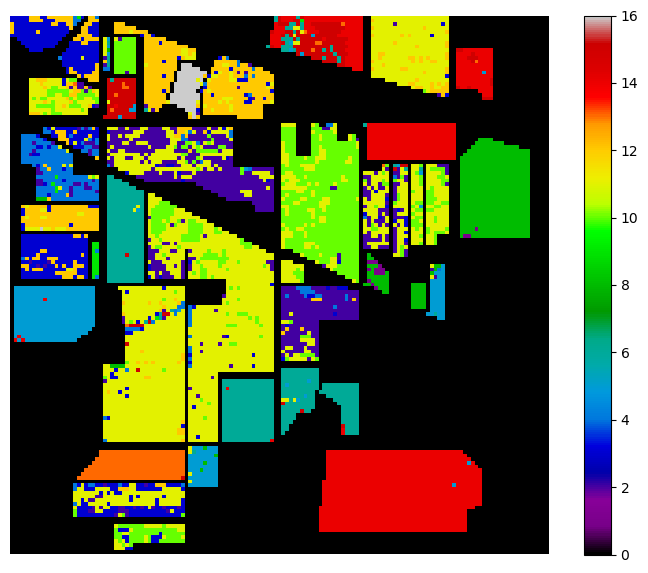

In [146]:
l = []
for i in tqdm(range(df.shape[0])):
  if df.iloc[i, -1] == 0:
    l.append(0)
  else:
    l.append(np.argmax(model.predict(df.iloc[i, :-1].values.reshape(-1, 200)), 1))
q = np.array(l).reshape(gt.shape).astype('float')
plot_data(q)